In [137]:
from jn_tools import data_prep 

d2, X, y, rs, X_train, X_test, y_train, y_test = data_prep()

In [183]:
from sklearn.tree import DecisionTreeClassifier, export_text, _tree
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd
import numpy as np

# simple decision tree training
model = DecisionTreeClassifier(random_state=rs)
model.fit(X_train, y_train)
model.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': 61,
 'splitter': 'best'}

In [141]:
print("Train accuracy:", model.score(X_train, y_train))

Train accuracy: 1.0


In [185]:
print("Test accuracy:", model.score(X_test, y_test))

Test accuracy: 0.6373056994818653


In [145]:
model.tree_.n_leaves # equivalent to number of rules

1008

In [147]:
model.tree_.node_count # number of nodes

2015

In [149]:
# source: https://mljar.com/blog/extract-rules-decision-tree/

def get_rule_count(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 3)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 3)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    
    rules = []
    for path in paths:
        rule = "if "
        
        for p in path[:-1]:
            if rule != "if ":
                rule += " and "
            rule += str(p)
        rule += " then "
        if class_names is None:
            rule += "response: "+str(np.round(path[-1][0][0][0],3))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"class: {class_names[l]} (proba: {np.round(100.0*classes[l]/np.sum(classes),2)}%)"
        rule += f" | based on {path[-1][1]:,} samples"
        rules += [rule]
        
    return len(rules)

In [151]:
get_rule_count(model, X.columns, None)

1008

In [153]:
# name of first split feature name
X.columns[first_split_feature_index]

'income_high'

In [155]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.69      0.69      1036
           1       0.55      0.56      0.56       701

    accuracy                           0.64      1737
   macro avg       0.62      0.63      0.62      1737
weighted avg       0.64      0.64      0.64      1737



In [157]:
# grab feature importances from the model and feature name from the original X
importances = model.feature_importances_
feature_names = X.columns

# sort them out in descending order
indices = np.argsort(importances)
indices = np.flip(indices, axis=0)

for i in indices:
    print(feature_names[i], ':', importances[i])

weight : 0.13941453768669052
height : 0.11377082940329641
contacts_count : 0.10035236503146555
income_high : 0.09319573009185216
worried : 0.07600402016795169
alcohol : 0.06760055024608104
blood_type_ap : 0.02304638158215197
blood_type_unknown : 0.022953290891509968
age_20_30 : 0.019691571536555187
working_travel critical : 0.019292917631286172
age_30_40 : 0.01897690812191233
insurance : 0.018480755074471385
working_stopped : 0.018049444193714913
blood_type_op : 0.016964531816908844
smoking_never : 0.016054566285089014
age_50_60 : 0.015459705758566825
smoking_quit5 : 0.0147128892103793
age_60_70 : 0.01454177785448164
age_40_50 : 0.01252730557230583
working_travel non critical : 0.012108530398064837
smoking_quit10 : 0.011946244227010329
working_never : 0.01188157884410507
gender_female : 0.011385461594474412
working_home : 0.01101914630426382
gender_male : 0.010695982841373759
age_10_20 : 0.010608074043408957
smoking_vape : 0.009681786496911683
blood_type_on : 0.009428912313642146
blood

In [159]:
import pydot
from io import StringIO
from sklearn.tree import export_graphviz

# Export the decision tree model to DOT format
dotfile = StringIO()
export_graphviz(
    model,
    out_file=dotfile,
    feature_names=X.columns,  # Replace X with your feature DataFrame
    filled=True,  # Color the nodes
    rounded=True,  # Rounded edges
    special_characters=True  # Allow special characters
)

# Generate the graph
graph = pydot.graph_from_dot_data(dotfile.getvalue())

# Since `graph_from_dot_data` returns a `Dot` object directly, no need for indexing
graph.write_png("d2_viz.png")  # Save the PNG

print("Decision tree visualization saved as 'd2_viz.png'")

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.807248 to fit

Decision tree visualization saved as 'd2_viz.png'


In [253]:
#retrain with a small max_depth limit

model_small = DecisionTreeClassifier(max_depth=3, random_state=rs)
model_small.fit(X_train, y_train)

print("Train accuracy:", model_small.score(X_train, y_train))
print("Test accuracy:", model_small.score(X_test, y_test))

y_pred_small = model_small.predict(X_test)
print(classification_report(y_test, y_pred_small))

Train accuracy: 0.6932379072063178
Test accuracy: 0.6954519286125503
              precision    recall  f1-score   support

           0       0.75      0.73      0.74      1036
           1       0.62      0.64      0.63       701

    accuracy                           0.70      1737
   macro avg       0.68      0.69      0.69      1737
weighted avg       0.70      0.70      0.70      1737



In [165]:
import numpy as np

# grab feature importances from the model and feature name from the original X
importances = model_small.feature_importances_
feature_names = X.columns

# sort them out in descending order
indices = np.argsort(importances)
indices = np.flip(indices, axis=0)

for i in indices:
    print(feature_names[i], ':', importances[i])

income_high : 0.5782050326572803
worried : 0.3247093022542382
weight : 0.040748662456435755
working_stopped : 0.0391566336528118
smoking_yesheavy : 0.01718036897923404
working_travel non critical : 0.0
age_10_20 : 0.0
age_70_80 : 0.0
age_60_70 : 0.0
age_50_60 : 0.0
age_40_50 : 0.0
age_30_40 : 0.0
age_20_30 : 0.0
gender_other : 0.0
age_100_110 : 0.0
age_0_10 : 0.0
blood_type_abp : 0.0
gender_male : 0.0
gender_female : 0.0
contacts_count : 0.0
alcohol : 0.0
insurance : 0.0
blood_type_abn : 0.0
blood_type_ap : 0.0
blood_type_an : 0.0
working_travel critical : 0.0
working_never : 0.0
working_home : 0.0
smoking_yesmedium : 0.0
smoking_yeslight : 0.0
smoking_vape : 0.0
smoking_quit5 : 0.0
smoking_quit10 : 0.0
smoking_quit0 : 0.0
smoking_never : 0.0
income_med : 0.0
income_low : 0.0
income_gov : 0.0
blood_type_unknown : 0.0
blood_type_op : 0.0
blood_type_on : 0.0
blood_type_bp : 0.0
blood_type_bn : 0.0
height : 0.0


In [167]:
# Export the decision tree model to DOT format
dotfile = StringIO()
export_graphviz(
    model_small,
    out_file=dotfile,
    feature_names=X.columns,  # Replace X with your feature DataFrame
    filled=True,  # Color the nodes
    rounded=True,  # Rounded edges
    special_characters=True  # Allow special characters
)

# Generate the graph
graph = pydot.graph_from_dot_data(dotfile.getvalue())
graph.write_png("d2_small_viz.png")  # Save the PNG

True

In [169]:
from sklearn.model_selection import GridSearchCV

In [171]:
params = {'criterion': ['gini', 'entropy'],
          'max_depth': range(1, 16),
          'min_samples_leaf': range(0, 25, 5)[1:]}

cv_1 = GridSearchCV(param_grid=params, estimator=DecisionTreeClassifier(random_state=rs),return_train_score=True, cv=10)
cv_1.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=61),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 16),
                         'min_samples_leaf': range(5, 25, 5)},
             return_train_score=True)

In [173]:
result_set = cv_1.cv_results_
print(result_set)

{'mean_fit_time': array([0.00484674, 0.00464838, 0.00456541, 0.00444255, 0.00521348,
       0.00521667, 0.00538547, 0.00538297, 0.00627811, 0.00625   ,
       0.00616293, 0.0062005 , 0.00690334, 0.00682323, 0.00670915,
       0.00668211, 0.00746937, 0.00742984, 0.00759797, 0.00766404,
       0.00835853, 0.00829093, 0.00825324, 0.00813713, 0.00942285,
       0.00902774, 0.00909638, 0.00884709, 0.00955081, 0.00967147,
       0.01003535, 0.00937319, 0.01037657, 0.0103369 , 0.01003668,
       0.00978374, 0.01096802, 0.01058528, 0.0100549 , 0.00980959,
       0.01136591, 0.01097333, 0.01118853, 0.01068382, 0.01181436,
       0.01152353, 0.01094341, 0.01063471, 0.01245456, 0.01164198,
       0.01119294, 0.01067553, 0.01246109, 0.01184301, 0.01119037,
       0.01060824, 0.01266696, 0.01196067, 0.01127954, 0.01058278,
       0.00445497, 0.00479026, 0.00489147, 0.00474687, 0.00532362,
       0.00530355, 0.00529466, 0.0054085 , 0.00678928, 0.00636687,
       0.00622194, 0.0059876 , 0.00675154, 0

Total number of models:  120


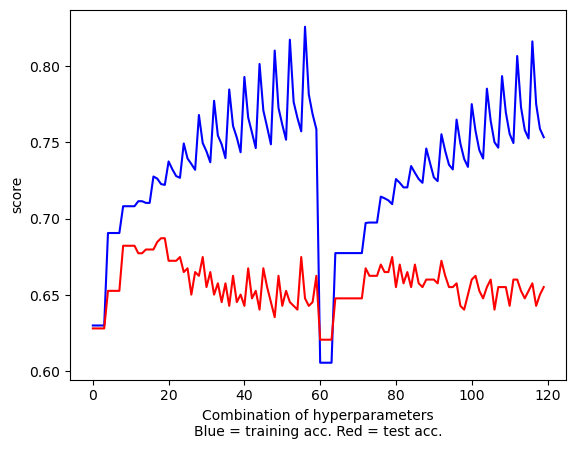

In [175]:
import matplotlib.pyplot as plt

train_result = result_set['split0_train_score']
test_result = result_set['split0_test_score']
print("Total number of models: ", len(test_result))
# plot max depth hyperparameter values vs training and test accuracy score
plt.plot(range(0, len(train_result)), train_result, 'b', range(0,len(test_result)), test_result, 'r')
plt.xlabel('Combination of hyperparameters\nBlue = training acc. Red = test acc.')
plt.ylabel('score')
plt.show()

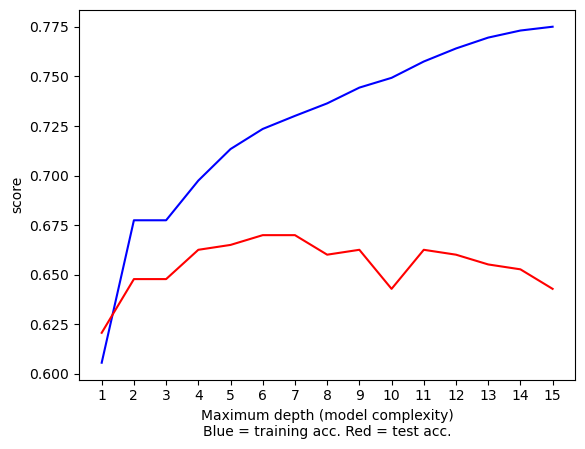

In [189]:
result_set['params']
dd = pd.DataFrame(result_set['params'])

index_ = list(dd.index[(dd['criterion']=='entropy') & (dd['min_samples_leaf']==10)])
max_depth_train = []
max_depth_test = []
for i in range(0,len(index_)):
    max_depth_train.append(train_result[index_[i]])
    max_depth_test.append(test_result[index_[i]])
plt.plot(range(1, len(max_depth_train)+1), max_depth_train, 'b', range(1,len(max_depth_test)+1), max_depth_test, 'r')
plt.xlabel('Maximum depth (model complexity)\nBlue = training acc. Red = test acc.')
plt.ylabel('score')
plt.xticks(np.arange(1, len(max_depth_train)+1, 1))
plt.show()

In [192]:
print(cv_1.best_params_)

{'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 5}


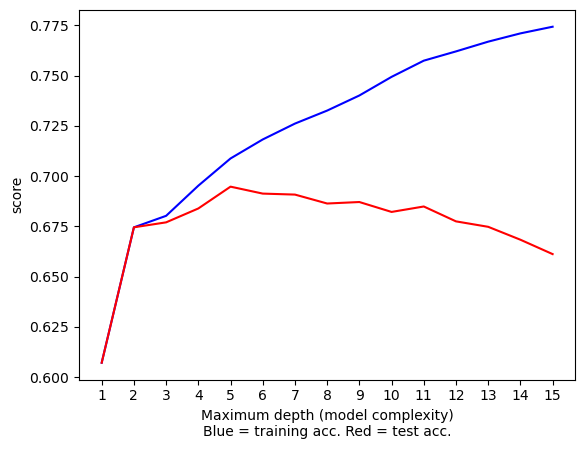

In [195]:
train_result = result_set['mean_train_score']
test_result = result_set['mean_test_score']

max_depth_train = []
max_depth_test = []
index_
for i in range(len(index_)):
    max_depth_train.append(train_result[index_[i]])
    max_depth_test.append(test_result[index_[i]])
plt.plot(range(1, len(max_depth_train)+1), max_depth_train, 'b', range(1,len(max_depth_test)+1), max_depth_test, 'r')
plt.xlabel('Maximum depth (model complexity)\nBlue = training acc. Red = test acc.')
plt.xticks(np.arange(1, len(max_depth_train)+1, 1))
plt.ylabel('score')
plt.show()

In [219]:
params = {
    'criterion': ['gini'],
    'max_depth': [6],
    'min_samples_leaf': [5],
    'max_features': [None, 'sqrt', 'log2'],
    'max_leaf_nodes': [None, 10, 20, 50],
    'min_impurity_decrease': [0.0, 0.01, 0.05],
    'splitter': ['best', 'random'],
    'class_weight': [None, 'balanced']
}
cv_1a = GridSearchCV(param_grid=params, estimator=DecisionTreeClassifier(random_state=rs),return_train_score=True, cv=10)
cv_1a.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=61),
             param_grid={'class_weight': [None, 'balanced'],
                         'criterion': ['gini'], 'max_depth': [6],
                         'max_features': [None, 'sqrt', 'log2'],
                         'max_leaf_nodes': [None, 10, 20, 50],
                         'min_impurity_decrease': [0.0, 0.01, 0.05],
                         'min_samples_leaf': [5],
                         'splitter': ['best', 'random']},
             return_train_score=True)

In [221]:
result_set_1a = cv_1a.cv_results_
print(result_set_1a)

{'mean_fit_time': array([0.01033142, 0.00699971, 0.00578797, 0.00468807, 0.00434532,
       0.00396411, 0.00691118, 0.00557692, 0.00553069, 0.00478311,
       0.00449154, 0.00402915, 0.00766039, 0.00606968, 0.00582805,
       0.00459011, 0.00433037, 0.00399642, 0.00798316, 0.00614164,
       0.00577087, 0.00460494, 0.0042907 , 0.00405402, 0.00421584,
       0.00428233, 0.00382264, 0.00394132, 0.00392318, 0.00382836,
       0.00435894, 0.00424688, 0.00390666, 0.00390744, 0.00376208,
       0.00382218, 0.00426056, 0.00423255, 0.00381072, 0.0038027 ,
       0.00365741, 0.00362732, 0.0042057 , 0.00410469, 0.00362134,
       0.00357711, 0.00361853, 0.00368009, 0.00422912, 0.0040719 ,
       0.00361702, 0.00361881, 0.00358722, 0.00361524, 0.00383768,
       0.00374794, 0.00355351, 0.00357831, 0.00354424, 0.00360384,
       0.00395279, 0.00387361, 0.00355825, 0.00357687, 0.00355268,
       0.00361073, 0.00408719, 0.00394728, 0.0036073 , 0.00378785,
       0.00375099, 0.00367384, 0.00830891, 0

In [223]:
print(cv_1a.best_params_)

{'class_weight': None, 'criterion': 'gini', 'max_depth': 6, 'max_features': None, 'max_leaf_nodes': 10, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 5, 'splitter': 'random'}


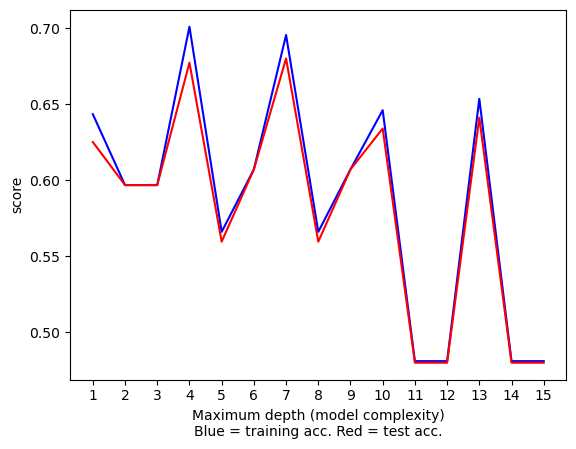

In [225]:
train_result = result_set_1a['mean_train_score']
test_result = result_set_1a['mean_test_score']

max_depth_train = []
max_depth_test = []
index_
for i in range(len(index_)):
    max_depth_train.append(train_result[index_[i]])
    max_depth_test.append(test_result[index_[i]])
plt.plot(range(1, len(max_depth_train)+1), max_depth_train, 'b', range(1,len(max_depth_test)+1), max_depth_test, 'r')
plt.xlabel('Maximum depth (model complexity)\nBlue = training acc. Red = test acc.')
plt.xticks(np.arange(1, len(max_depth_train)+1, 1))
plt.ylabel('score')
plt.show()

In [229]:
# optimal decision tree training
optimal_model = DecisionTreeClassifier(class_weight= None, criterion='gini', max_depth=6, max_features=None, max_leaf_nodes=10, min_impurity_decrease=0.0, min_samples_leaf=5, random_state=rs, splitter='random')
optimal_model.fit(X_train, y_train)
optimal_model.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 6,
 'max_features': None,
 'max_leaf_nodes': 10,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': 61,
 'splitter': 'random'}

In [233]:
print("Train accuracy:", optimal_model.score(X_train, y_train))

Train accuracy: 0.691263573543929


In [235]:
print("Test accuracy:", optimal_model.score(X_test, y_test))

Test accuracy: 0.689119170984456


In [ ]:
y_pred_optimal = optimal_model.predict(X_test)
print(classification_report(y_test, y_pred))

In [237]:
get_rule_count(optimal_model, X.columns, None)

10

In [244]:
optimal_model.tree_.node_count # number of nodes

19

In [246]:
# grab feature importances from the model and feature name from the original X
importances = optimal_model.feature_importances_
feature_names = X.columns

# sort them out in descending order
indices = np.argsort(importances)
indices = np.flip(indices, axis=0)

for i in indices:
    print(feature_names[i], ':', importances[i])

income_high : 0.5791998451589087
worried : 0.16450489603474816
working_travel critical : 0.1103853462613169
working_stopped : 0.0738059191836583
income_med : 0.02956475619768735
income_low : 0.025329309040409757
smoking_yesheavy : 0.017209928123270858
working_travel non critical : 0.0
age_60_70 : 0.0
age_50_60 : 0.0
age_40_50 : 0.0
age_30_40 : 0.0
age_20_30 : 0.0
age_10_20 : 0.0
age_100_110 : 0.0
age_0_10 : 0.0
blood_type_abn : 0.0
gender_other : 0.0
gender_male : 0.0
gender_female : 0.0
contacts_count : 0.0
alcohol : 0.0
insurance : 0.0
weight : 0.0
age_70_80 : 0.0
blood_type_ap : 0.0
blood_type_abp : 0.0
blood_type_an : 0.0
working_never : 0.0
working_home : 0.0
smoking_yesmedium : 0.0
smoking_yeslight : 0.0
smoking_vape : 0.0
smoking_quit5 : 0.0
smoking_quit10 : 0.0
smoking_quit0 : 0.0
smoking_never : 0.0
income_gov : 0.0
blood_type_unknown : 0.0
blood_type_op : 0.0
blood_type_on : 0.0
blood_type_bp : 0.0
blood_type_bn : 0.0
height : 0.0


In [241]:
# Export the decision tree model to DOT format
dotfile = StringIO()
export_graphviz(
    optimal_model,
    out_file=dotfile,
    feature_names=X.columns,  # Replace X with your feature DataFrame
    filled=True,  # Color the nodes
    rounded=True,  # Rounded edges
    special_characters=True  # Allow special characters
)

# Generate the graph
graph = pydot.graph_from_dot_data(dotfile.getvalue())

# Since `graph_from_dot_data` returns a `Dot` object directly, no need for indexing
graph.write_png("d2_optimal_viz.png")  # Save the PNG

True

In [257]:
y_pred_default = model.predict(X_test)
y_pred_optimal = optimal_model.predict(X_test)

print("Accuracy score on test for default:", accuracy_score(y_test, y_pred_default))
print("Accuracy score on test for optimal", accuracy_score(y_test, y_pred_optimal))

Accuracy score on test for default: 0.6373056994818653
Accuracy score on test for optimal 0.689119170984456


In [310]:
dt_optimal_best = cv_1a.best_estimator_
# probability prediction from decision tree
y_pred_proba_optimal = dt_optimal_best.predict_proba(X_test)

print("Probability produced by decision tree for each class vs actual prediction on TargetB (0 = non-donor, 1 = donor). You should be able to see the default threshold of 0.5.")
print("(Probs on zero)\t(probs on one)\t(prediction made)")
# print top 10
for i in range(50):
    print(y_pred_proba_optimal[i][0], '\t', y_pred_proba_optimal[i][1], '\t', y_pred_optimal[i])


Probability produced by decision tree for each class vs actual prediction on TargetB (0 = non-donor, 1 = donor). You should be able to see the default threshold of 0.5.
(Probs on zero)	(probs on one)	(prediction made)
0.7391304347826086 	 0.2608695652173913 	 0
0.6 	 0.4 	 0
0.7528735632183908 	 0.2471264367816092 	 0
0.3475836431226766 	 0.6524163568773235 	 1
0.7712053571428571 	 0.22879464285714285 	 0
0.5670995670995671 	 0.4329004329004329 	 0
0.5670995670995671 	 0.4329004329004329 	 0
0.328525641025641 	 0.6714743589743589 	 1
0.5670995670995671 	 0.4329004329004329 	 0
0.7528735632183908 	 0.2471264367816092 	 0
0.328525641025641 	 0.6714743589743589 	 1
0.7712053571428571 	 0.22879464285714285 	 0
0.7712053571428571 	 0.22879464285714285 	 0
0.7712053571428571 	 0.22879464285714285 	 0
0.328525641025641 	 0.6714743589743589 	 1
0.328525641025641 	 0.6714743589743589 	 1
0.5670995670995671 	 0.4329004329004329 	 0
0.5670995670995671 	 0.4329004329004329 	 0
0.3475836431226766 	

In [314]:
# Extract decision tree rules
from sklearn.tree import export_text

tree_rules = export_text(dt_optimal_best, feature_names=list(X.columns))
print(tree_rules)

|--- income_high <= 0.41
|   |--- working_travel critical <= 0.56
|   |   |--- worried <= 4.42
|   |   |   |--- working_stopped <= 0.29
|   |   |   |   |--- class: 0
|   |   |   |--- working_stopped >  0.29
|   |   |   |   |--- worried <= 3.99
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- worried >  3.99
|   |   |   |   |   |--- income_low <= 0.54
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- income_low >  0.54
|   |   |   |   |   |   |--- class: 0
|   |   |--- worried >  4.42
|   |   |   |--- class: 0
|   |--- working_travel critical >  0.56
|   |   |--- income_med <= 0.32
|   |   |   |--- class: 0
|   |   |--- income_med >  0.32
|   |   |   |--- class: 1
|--- income_high >  0.41
|   |--- working_stopped <= 0.27
|   |   |--- smoking_yesheavy <= 0.22
|   |   |   |--- class: 0
|   |   |--- smoking_yesheavy >  0.22
|   |   |   |--- class: 1
|   |--- working_stopped >  0.27
|   |   |--- class: 0



In [321]:
# Generate classification report
report = classification_report(y_test, y_pred_optimal, target_names=['COVID Negative', 'COVID Positive'])
print("Classification Report:\n", report)

Classification Report:
                 precision    recall  f1-score   support

COVID Negative       0.70      0.83      0.76      1036
COVID Positive       0.66      0.48      0.55       701

      accuracy                           0.69      1737
     macro avg       0.68      0.65      0.66      1737
  weighted avg       0.68      0.69      0.68      1737



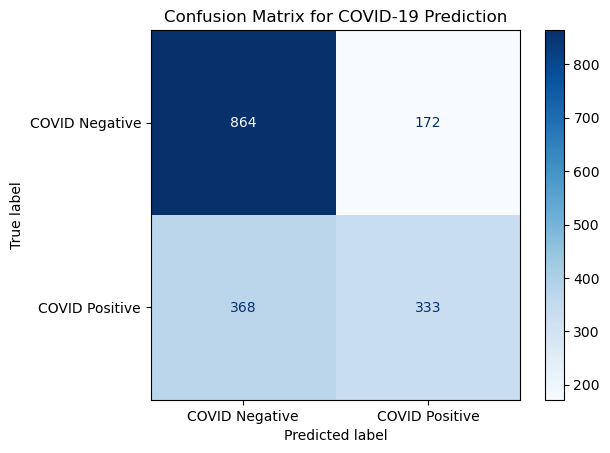

In [326]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred_optimal)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['COVID Negative', 'COVID Positive'])

# Plot confusion matrix
cm_display.plot(cmap='Blues')
plt.title('Confusion Matrix for COVID-19 Prediction')
plt.savefig("optimal_confusion_matrix.png", dpi=300)
plt.show()


In [296]:
from sklearn.metrics import roc_auc_score

y_pred_proba = model.predict_proba(X_test)

roc_index = roc_auc_score(y_test, y_pred_proba[:, 1])
roc_index_optimal = roc_auc_score(y_test, y_pred_proba_optimal[:, 1])

print("ROC index on test for default:", roc_index)
print("ROC index on test for optimal:", roc_index_optimal)

ROC index on test for default: 0.6253697145280597
ROC index on test for optimal: 0.7194603407156902


In [274]:
from sklearn.metrics import roc_curve

fpr_default, tpr_default, thresholds_default = roc_curve(y_test, y_pred_proba[:,1])
fpr_optimal, tpr_optimal, thresholds_optimal = roc_curve(y_test, y_pred_proba_optimal[:,1])

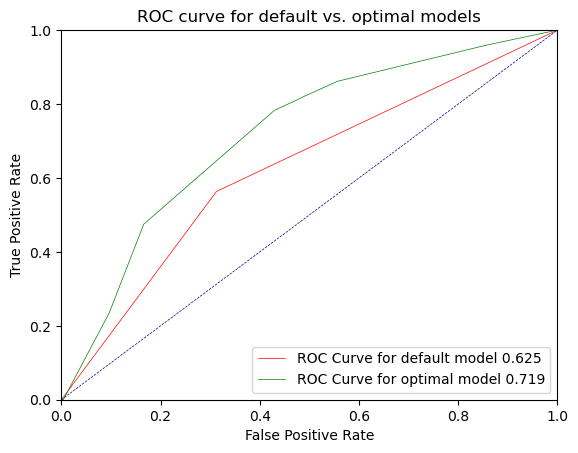

In [298]:
import matplotlib.pyplot as plt

plt.plot(fpr_default, tpr_default, label='ROC Curve for default model {:.3f}'.format(roc_index), color='red', lw=0.5)
plt.plot(fpr_optimal, tpr_optimal, label='ROC Curve for optimal model {:.3f}'.format(roc_index_optimal), color='green', lw=0.5)
plt.plot([0, 1], [0, 1], color='navy', lw=0.5, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for default vs. optimal models')
plt.legend(loc="lower right")
plt.savefig("d2_roc_curve.png", dpi=300)
plt.show()

In [301]:
import pickle
dt_best = cv_1a
with open('DT.pickle', 'wb') as f:
    pickle.dump([dt_best,roc_index_optimal, fpr_optimal, tpr_optimal], f)

-----------

## Logistic regression

In [337]:
d2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5789 entries, 0 to 5788
Data columns (total 45 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   height                       5789 non-null   int64
 1   weight                       5789 non-null   int64
 2   insurance                    5789 non-null   int64
 3   alcohol                      5789 non-null   int64
 4   contacts_count               5789 non-null   int64
 5   worried                      5789 non-null   int64
 6   covid19_positive             5789 non-null   int64
 7   gender_female                5789 non-null   bool 
 8   gender_male                  5789 non-null   bool 
 9   gender_other                 5789 non-null   bool 
 10  age_0_10                     5789 non-null   bool 
 11  age_100_110                  5789 non-null   bool 
 12  age_10_20                    5789 non-null   bool 
 13  age_20_30                    5789 non-null   boo

In [343]:
## continuing with logistic regression in the same workbook

from sklearn.preprocessing import StandardScaler

# initialise a standard scaler object
scaler = StandardScaler()

# visualise min, max, mean and standard dev of data before scaling
print("Before scaling\n-------------")
for i in range(44):
    col = X_train[:,i]
    print("Variable #{}: min {}, max {}, mean {:.2f} and std dev {:.2f}".
          format(i, min(col), max(col), np.mean(col), np.std(col)))

# learn the mean and std.dev of variables from training data
# then use the learned values to transform training data
X_train = scaler.fit_transform(X_train, y_train)

print("After scaling\n-------------")
for i in range(44):
    col = X_train[:,i]
    print("Variable #{}: min {}, max {}, mean {:.2f} and std dev {:.2f}".
          format(i, min(col), max(col), np.mean(col), np.std(col)))

# use the statistic that you learned from training to transform test data
# NEVER learn from test data, this is supposed to be a set of dataset
# that the model has never seen before
X_test = scaler.transform(X_test)


Before scaling
-------------
Variable #0: min -5.715166836033324, max 6.073563738208654, mean -0.00 and std dev 1.00
Variable #1: min -1.7201452240977413, max 4.041889575394031, mean -0.00 and std dev 1.00
Variable #2: min -2.879857284945, max 0.34723942926881024, mean -0.00 and std dev 1.00
Variable #3: min -0.8508651781060833, max 3.703138013100815, mean 0.00 and std dev 1.00
Variable #4: min -1.1715942989338957, max 1.9167979589621098, mean -0.00 and std dev 1.00
Variable #5: min -3.6674183119761743, max 1.8847501917142642, mean 0.00 and std dev 1.00
Variable #6: min -0.9622138604842384, max 1.0392700012622376, mean 0.00 and std dev 1.00
Variable #7: min -1.0351688954594345, max 0.9660259348848534, mean -0.00 and std dev 1.00
Variable #8: min -0.04447740288015261, max 22.48332715591712, mean -0.00 and std dev 1.00
Variable #9: min -0.04973954926423878, max 20.10472581260528, mean -0.00 and std dev 1.00
Variable #10: min -0.035149439168812135, max 28.449956063236314, mean -0.00 and s

In [352]:
from sklearn.linear_model import LogisticRegression

regression_model = LogisticRegression(random_state=rs)

# fit it to training data
regression_model.fit(X_train, y_train)

LogisticRegression(random_state=61)

In [355]:
regression_model.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 61,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [360]:
# training and test accuracy
print("Train accuracy:", regression_model.score(X_train, y_train))
print("Test accuracy:", regression_model.score(X_test, y_test))

# classification report on test data
y_pred_regression = regression_model.predict(X_test)
print(classification_report(y_test, y_pred_regression))

Train accuracy: 0.6853405725567621
Test accuracy: 0.6931491076568796
              precision    recall  f1-score   support

           0       0.72      0.79      0.75      1036
           1       0.64      0.55      0.59       701

    accuracy                           0.69      1737
   macro avg       0.68      0.67      0.67      1737
weighted avg       0.69      0.69      0.69      1737



In [365]:
print(regression_model.coef_)

[[-0.15846762  0.29215889  0.11047006  0.04117288  0.02251562  0.13226272
  -0.04378701  0.04020187  0.04028743 -0.00329659  0.21493224  0.03909144
   0.11843024  0.03311356 -0.02663947  0.03976894 -0.12954163 -0.1442229
  -0.00955947  0.05021632 -0.02478216 -0.00772621 -0.00985674  0.02557983
  -0.03474487 -0.02610144  0.03184873  0.06492366 -0.34736453 -0.02583579
   0.32860857 -0.03633661  0.01274475  0.06807362 -0.0747712   0.03361658
   0.10086019 -0.02082738  0.01443737 -0.13656985  0.00769476 -0.06962288
   0.22622523 -0.08835656]]


In [582]:
# Grab coefficients from the model and feature names from the original X
coef = regression_model.coef_[0]
feature_names = X.columns

# Sort them out in descending order based on absolute values of the coefficients
indices = np.argsort(np.absolute(coef))
indices = np.flip(indices, axis=0)

# Print feature names, coefficients, and absolute values of the coefficients
for i in indices:
    print(f"{feature_names[i]:<30} : {coef[i]:<10} abs: {np.absolute(coef[i]):<10}")

income_high                    : -0.34736453394971856 abs: 0.34736453394971856
income_med                     : 0.3286085718049873 abs: 0.3286085718049873
weight                         : 0.2921588882248638 abs: 0.2921588882248638
working_travel critical        : 0.2262252325578695 abs: 0.2262252325578695
age_100_110                    : 0.21493223967953348 abs: 0.21493223967953348
height                         : -0.1584676190242466 abs: 0.1584676190242466
age_70_80                      : -0.14422290407915378 abs: 0.14422290407915378
working_home                   : -0.13656984566948585 abs: 0.13656984566948585
worried                        : 0.13226272157797803 abs: 0.13226272157797803
age_60_70                      : -0.12954163181872755 abs: 0.12954163181872755
age_20_30                      : 0.11843024078585722 abs: 0.11843024078585722
insurance                      : 0.11047006481590355 abs: 0.11047006481590355
smoking_yesheavy               : 0.10086019330637944 abs: 0.1008601

In [557]:
# tuning C via GridSearchCV

# grid search CV
params = {'C': [pow(10, x) for x in range(-6, 4)],
          'penalty': ['l2'],
         'solver': ['liblinear', 'newton-cholesky']}

# use all cores to tune logistic regression with C parameter
regression_optimal_c = GridSearchCV(param_grid=params, estimator=LogisticRegression(random_state=rs),return_train_score=True, cv=10, n_jobs=-1)
regression_optimal_c.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(random_state=61), n_jobs=-1,
             param_grid={'C': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10,
                               100, 1000],
                         'penalty': ['l2'],
                         'solver': ['liblinear', 'newton-cholesky']},
             return_train_score=True)

In [559]:
regression_optimal_c_result_set = regression_optimal_c.cv_results_
print(regression_optimal_c_result_set)

{'mean_fit_time': array([0.01833611, 0.00821223, 0.0055275 , 0.00424047, 0.0068717 ,
       0.00900502, 0.01134515, 0.01028175, 0.01347706, 0.00803316,
       0.01639776, 0.00831177, 0.02209806, 0.01320417, 0.02454579,
       0.01027911, 0.02221196, 0.00733202, 0.01969976, 0.00761163]), 'std_fit_time': array([0.0056275 , 0.00399862, 0.00207046, 0.00142035, 0.00314846,
       0.00377554, 0.00702686, 0.00530154, 0.00367737, 0.00279338,
       0.00616279, 0.00407493, 0.0098729 , 0.0095119 , 0.00875925,
       0.00524913, 0.00956245, 0.00208191, 0.00411718, 0.00289042]), 'mean_score_time': array([0.00310583, 0.00068719, 0.00058029, 0.00044186, 0.00057583,
       0.00081213, 0.00129619, 0.00062134, 0.00103819, 0.0008631 ,
       0.00087302, 0.00063829, 0.00079703, 0.00074399, 0.00114491,
       0.00063813, 0.0005991 , 0.00107446, 0.00065496, 0.00066493]), 'std_score_time': array([0.00181877, 0.00020163, 0.00022276, 0.00015767, 0.00034098,
       0.00041555, 0.00071838, 0.00021989, 0.0007339

Total number of models:  20


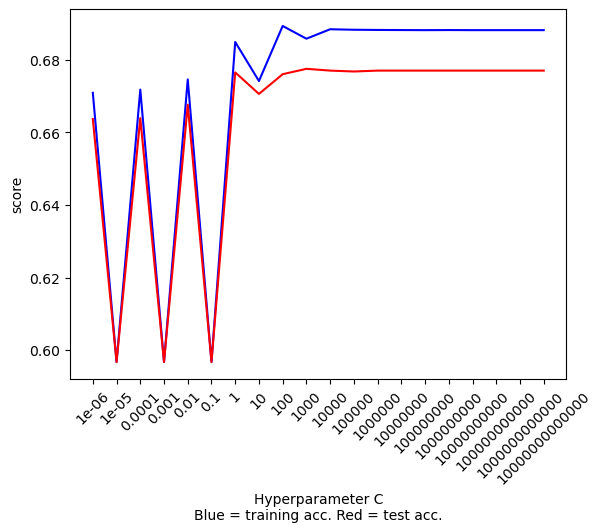

In [561]:
import matplotlib.pyplot as plt

train_result = regression_optimal_c_result_set['mean_train_score']
test_result = regression_optimal_c_result_set['mean_test_score']
print("Total number of models: ", len(test_result))
# plot Hyperparameter C values vs training and test accuracy score
plt.plot(range(0, len(train_result)), train_result, 'b', range(0,len(test_result)), test_result, 'r')
plt.xlabel('Hyperparameter C\nBlue = training acc. Red = test acc.')
plt.xticks(range(0, len(train_result)),[pow(10, x) for x in range(-6, 14)], rotation=45)
plt.ylabel('score')
plt.show()

In [563]:
print(regression_optimal_c.best_params_)

{'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cholesky'}


In [592]:
regression_model_optimal_c = LogisticRegression(C=0.01, solver='newton-cholesky', penalty='l2', random_state=rs)

# fit it to training data
regression_model_optimal_c.fit(X_train, y_train)

LogisticRegression(C=0.01, random_state=61, solver='newton-cholesky')

In [594]:
# training and test accuracy
print("Train accuracy:", regression_optimal_c.score(X_train, y_train))
print("Test accuracy:", regression_optimal_c.score(X_test, y_test))

# classification report on test data
y_pred_regression_optimal_c = regression_optimal_c.predict(X_test)
print(classification_report(y_test, y_pred_regression_optimal_c))

Train accuracy: 0.6875616979269497
Test accuracy: 0.694300518134715
              precision    recall  f1-score   support

           0       0.72      0.80      0.76      1036
           1       0.65      0.54      0.59       701

    accuracy                           0.69      1737
   macro avg       0.68      0.67      0.67      1737
weighted avg       0.69      0.69      0.69      1737



Not a lot of improvement.

In [586]:
# Grab coefficients from the model and feature names from the original X
coef = regression_model_optimal_c.coef_[0]
feature_names = X.columns

# Sort them out in descending order based on absolute values of the coefficients
indices = np.argsort(np.absolute(coef))
indices = np.flip(indices, axis=0)

# Print feature names, coefficients, and absolute values of the coefficients
for i in indices:
    print(f"{feature_names[i]:<30} : {coef[i]:<10} abs: {np.absolute(coef[i]):<10}")

income_high                    : -0.3228880415180645 abs: 0.3228880415180645
income_med                     : 0.30723264584212845 abs: 0.30723264584212845
weight                         : 0.25113490624686535 abs: 0.25113490624686535
working_travel critical        : 0.20600591201101126 abs: 0.20600591201101126
age_70_80                      : -0.1221593636281359 abs: 0.1221593636281359
worried                        : 0.12168939802509429 abs: 0.12168939802509429
working_home                   : -0.12063405715384569 abs: 0.12063405715384569
height                         : -0.11440775381404908 abs: 0.11440775381404908
age_60_70                      : -0.1140077741592616 abs: 0.1140077741592616
age_20_30                      : 0.10607971456787195 abs: 0.10607971456787195
age_100_110                    : 0.09760477059414664 abs: 0.09760477059414664
insurance                      : 0.0953625700357334 abs: 0.0953625700357334
smoking_yesheavy               : 0.08830886652475246 abs: 0.0883088

In [484]:
from sklearn.feature_selection import RFECV

rfe_model = RFECV(estimator = LogisticRegression(random_state=rs), cv=10)
rfe_model.fit(X_train, y_train) # run the RFECV

# comparing how many variables before and after
print("Original feature set", X_train.shape[1])
print("Number of features after elimination", rfe_model.n_features_)

Original feature set 44
Number of features after elimination 32


In [486]:
X_train_rfe = rfe_model.transform(X_train)
X_test_rfe = rfe_model.transform(X_test)

In [590]:
# grid search CV
params = {'C': [pow(10, x) for x in range(-6, 4)]}

rfe_optimal_c = GridSearchCV(param_grid=params, estimator=LogisticRegression(random_state=rs), cv=10, n_jobs=-1)
rfe_optimal_c.fit(X_train_rfe, y_train)

# test the best model
print("Train accuracy:", rfe_optimal_c.score(X_train_rfe, y_train))
print("Test accuracy:", rfe_optimal_c.score(X_test_rfe, y_test))

y_pred_rfe_optimal_c = rfe_optimal_c.predict(X_test_rfe)
print(classification_report(y_test, y_pred_rfe_optimal_c))

# print parameters of the best model
print(rfe_optimal_c.best_params_)

Train accuracy: 0.6875616979269497
Test accuracy: 0.697754749568221
              precision    recall  f1-score   support

           0       0.72      0.80      0.76      1036
           1       0.65      0.55      0.60       701

    accuracy                           0.70      1737
   macro avg       0.69      0.67      0.68      1737
weighted avg       0.69      0.70      0.69      1737

{'C': 0.1}


In [602]:
# Grab coefficients from the model and feature names from the original X
coef = rfe_model.estimator_.coef_[0]
feature_names = X.columns

# Sort them out in descending order based on absolute values of the coefficients
indices = np.argsort(np.absolute(coef))
indices = np.flip(indices, axis=0)

# Print feature names, coefficients, and absolute values of the coefficients
for i in indices:
    print(f"{feature_names[i]:<30} : {coef[i]:<10} abs: {np.absolute(coef[i]):<10}")

blood_type_an                  : -0.34748460786444246 abs: 0.34748460786444246
blood_type_bn                  : 0.32842512946011204 abs: 0.32842512946011204
weight                         : 0.2912121155412531 abs: 0.2912121155412531
income_med                     : 0.22787769509912148 abs: 0.22787769509912148
gender_other                   : 0.21963471545791546 abs: 0.21963471545791546
height                         : -0.15814620418342962 abs: 0.15814620418342962
age_50_60                      : -0.14522041339110212 abs: 0.14522041339110212
income_high                    : -0.14231939718430311 abs: 0.14231939718430311
contacts_count                 : 0.13080851299729113 abs: 0.13080851299729113
age_40_50                      : -0.1299644071186225 abs: 0.1299644071186225
age_100_110                    : 0.1218682214724742 abs: 0.1218682214724742
insurance                      : 0.1111606498444884 abs: 0.1111606498444884
blood_type_op                  : -0.09884488368471374 abs: 0.098844

In [496]:
with open('DT.pickle', 'rb') as f:
    dt_best,roc_index_optimal, fpr_optimal, tpr_optimal = pickle.load(f)

print(dt_best.best_params_)

{'class_weight': None, 'criterion': 'gini', 'max_depth': 6, 'max_features': None, 'max_leaf_nodes': 10, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 5, 'splitter': 'random'}


In [580]:
# grab feature importances from the model and feature name from the original X
importances = dt_best.best_estimator_.feature_importances_
feature_names = X.columns

# sort them out in descending order
indices = np.argsort(importances)
indices = np.flip(indices, axis=0)

for i in indices:
    print(feature_names[i], ':', importances[i])


income_high : 0.5791998451589087
worried : 0.16450489603474816
working_travel critical : 0.1103853462613169
working_stopped : 0.0738059191836583
income_med : 0.02956475619768735
income_low : 0.025329309040409757
smoking_yesheavy : 0.017209928123270858
working_travel non critical : 0.0
age_60_70 : 0.0
age_50_60 : 0.0
age_40_50 : 0.0
age_30_40 : 0.0
age_20_30 : 0.0
age_10_20 : 0.0
age_100_110 : 0.0
age_0_10 : 0.0
blood_type_abn : 0.0
gender_other : 0.0
gender_male : 0.0
gender_female : 0.0
contacts_count : 0.0
alcohol : 0.0
insurance : 0.0
weight : 0.0
age_70_80 : 0.0
blood_type_ap : 0.0
blood_type_abp : 0.0
blood_type_an : 0.0
working_never : 0.0
working_home : 0.0
smoking_yesmedium : 0.0
smoking_yeslight : 0.0
smoking_vape : 0.0
smoking_quit5 : 0.0
smoking_quit10 : 0.0
smoking_quit0 : 0.0
smoking_never : 0.0
income_gov : 0.0
blood_type_unknown : 0.0
blood_type_op : 0.0
blood_type_on : 0.0
blood_type_bp : 0.0
blood_type_bn : 0.0
height : 0.0


Only seven features are important.

In [506]:
from sklearn.feature_selection import SelectFromModel

# use the trained best decision tree from GridSearchCV to select features
# supply the prefit=True parameter to stop SelectFromModel to re-train the model
selectmodel = SelectFromModel(dt_best.best_estimator_, prefit=True)
X_train_selected_features_model = selectmodel.transform(X_train)
X_test_selected_features_model = selectmodel.transform(X_test)

print(X_train_selected_features_model.shape)

(4052, 6)


In [511]:
params = {'C': [pow(10, x) for x in range(-6, 4)]}

### For the params given, build a logistic regression model with GridSearch.

cv_selected_features_model = GridSearchCV(param_grid=params, estimator=LogisticRegression(random_state=rs), cv=10, n_jobs=-1)
cv_selected_features_model.fit(X_train_selected_features_model, y_train)

print("Train accuracy:", cv_selected_features_model.score(X_train_selected_features_model, y_train))
print("Test accuracy:", cv_selected_features_model.score(X_test_selected_features_model, y_test))

# test the best model
y_pred_selected_features = cv_selected_features_model.predict(X_test_selected_features_model)
print(classification_report(y_test, y_pred_selected_features))

# print parameters of the best model
print(cv_selected_features_model.best_params_)

Train accuracy: 0.6762092793682132
Test accuracy: 0.6747265400115141
              precision    recall  f1-score   support

           0       0.70      0.79      0.74      1036
           1       0.62      0.50      0.55       701

    accuracy                           0.67      1737
   macro avg       0.66      0.65      0.65      1737
weighted avg       0.67      0.67      0.67      1737

{'C': 10}


In [604]:
y_pred_proba_regression = model.predict_proba(X_test)
y_pred_proba_regression_optimal_c = regression_optimal_c.predict_proba(X_test)
y_pred_proba_rfe_optimal_c = rfe_optimal_c.predict_proba(X_test_rfe)
y_pred_proba_regression_selected_features = cv_selected_features_model.predict_proba(X_test_selected_features_model)

roc_index = roc_auc_score(y_test, y_pred_proba_regression[:, 1])
roc_index_regression_optimal_c = roc_auc_score(y_test, y_pred_proba_regression_optimal_c[:, 1])
roc_index_rfe_optimal_c = roc_auc_score(y_test, y_pred_proba_rfe_optimal_c[:, 1])
roc_index_regression_selected_features = roc_auc_score(y_test, y_pred_proba_regression_selected_features[:, 1])


print("ROC index on test for default regression:", roc_index)
print("ROC index on test for regression model with optimal C:", roc_index_regression_optimal_c)
print("ROC index on test for RFE regression model with optimal C:", roc_index_rfe_optimal_c)
print("ROC index on test for regression model with optimal C and selected features from decision tree:", roc_index_selected_features)


ROC index on test for default regression: 0.44429359051327666
ROC index on test for regression model with optimal C: 0.7447482636498328
ROC index on test for RFE regression model with optimal C: 0.7460963102903189
ROC index on test for regression model with optimal C and selected features from decision tree: 0.7117438408451247


In [606]:
fpr_regression_default, tpr_regression_default, thresholds_regression_default = roc_curve(y_test, y_pred_proba_regression[:,1])
fpr_regression_optimal_c, tpr_regression_optimal_c, thresholds_regression_optimal_c = roc_curve(y_test, y_pred_proba_regression_optimal_c[:,1])
fpr_rfe_optimal_c, tpr_rfe_optimal_c, thresholds_rfe_optimal_c = roc_curve(y_test, y_pred_proba_rfe_optimal_c[:,1])
fpr_regression_selected_features, tpr_regression_selected_features, thresholds_regression_selected_features = roc_curve(y_test, y_pred_proba_regression_selected_features[:,1])



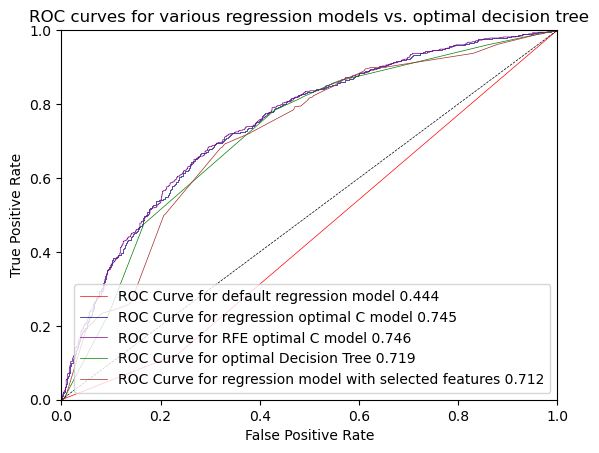

In [619]:
plt.plot(fpr_regression_default, tpr_regression_default, label='ROC Curve for default regression model {:.3f}'.format(roc_index), color='red', lw=0.5)
plt.plot(fpr_regression_optimal_c, tpr_regression_optimal_c, label='ROC Curve for regression optimal C model {:.3f}'.format(roc_index_regression_optimal_c), color='navy', lw=0.5)
plt.plot(fpr_rfe_optimal_c, tpr_rfe_optimal_c, label='ROC Curve for RFE optimal C model {:.3f}'.format(roc_index_rfe_optimal_c), color='purple', lw=0.5)
plt.plot(fpr_optimal, tpr_optimal, label='ROC Curve for optimal Decision Tree {:.3f}'.format(roc_index_optimal), color='green', lw=0.5)
plt.plot(fpr_regression_selected_features, tpr_regression_selected_features, label='ROC Curve for regression model with selected features {:.3f}'.format(roc_index_regression_selected_features), color='brown', lw=0.5)
plt.plot([0, 1], [0, 1], color='black', lw=0.5, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for various regression models vs. optimal decision tree')
plt.legend(loc="lower right")
plt.savefig("d2_regression_roc_curve.png", dpi=300)
plt.show()

## Neural networks

In [659]:
from sklearn.neural_network import MLPClassifier

model_1 = MLPClassifier(random_state=rs)
model_1.fit(X_train, y_train)

print("Train accuracy:", model_1.score(X_train, y_train))
print("Test accuracy:", model_1.score(X_test, y_test))

y_pred = model_1.predict(X_test)
print(classification_report(y_test, y_pred))

print(model_1)

Train accuracy: 0.8877097729516288
Test accuracy: 0.6689694876223373
              precision    recall  f1-score   support

           0       0.72      0.73      0.73      1036
           1       0.59      0.57      0.58       701

    accuracy                           0.67      1737
   macro avg       0.66      0.65      0.65      1737
weighted avg       0.67      0.67      0.67      1737

MLPClassifier(random_state=61)


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


##### I note the convergence warning. Let's see what parameters MLPClassifier model_1 takes.

In [661]:
model_1.get_params()

{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (100,),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 200,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': 61,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}



'activation': Defines the activation function for the hidden layers. The default value, 'relu' (Rectified Linear Unit), is a widely used function that outputs the input directly if it’s positive, otherwise, it outputs zero. Other possible in

'alpha': This parameter helps prevent overfitting by penalising features with large weights. A higher value increases regularisation strength. The default value is 0.0001.

'batch_size': Defines the size of mini-batches used in training. The default value, 'auto', sets it to the size of the training dataset for the 'adam' solver, or to 200 for 'sgd' solver.

'beta_1': Used in the Adam optimiser, this parameter represents the exponential decay rate for the first moment estimate. It controls the momentum for updating the model’s weights. 0.9 is the default value.

'beta_2': The exponential decay rate for the second moment estimate in the Adam optimiser. It helps correct the bias in the moment estimates. 0.999 is the default value.

'early_stopping': If True, the training stops early if the validation score doesn’t improve for a given number of iterations (i.e. 'n_iter_no_change'). It prevents overfitting by stopping training before the model starts to memorize the data. The default value is False.

'epsilon': Used in the Adam optimiser, this parameter represents a small constant added to avoid division by zero in calculations. The default value is 1e-08.

'hidden_layer_sizes': This specifies the number of neurons in each hidden layer. (100,) means a single hidden layer with 100 neurons. You can specify more hidden layers like (100, 50) for two layers with 100 and 50 neurons, respectively. The default value for this parameter, (100,) represents one hidden layer with 100 neurons.

'learning_rate': Defines the learning rate schedule. 'constant', the default value, means that the learning rate remains the same throughout training. Other options are 'invscaling' and 'adaptive'.
'learning_rate_init': The initial learning rate. This controls how much to change the model’s weights in response to the estimated error. The default value is 0.001.

'max_fun': This represents the number of function evaluations during optimization. This is specific to certain solvers like 'lbfgs' and 'sgd'. It may not be used if you're using the 'adam' solver. 15000 is the default value.

'max_iter': The maximum number of iterations (epochs) to train the model. If early_stopping=True, training may stop earlier if performance on the validation set doesn’t improve. 'max_iter' is 200 by default; we know we will have to increase this as we are already getting a convergence warning with the default neural network build.

'momentum': Momentum factor used in the optimization algorithm. Helps accelerate gradient descent in the right direction. The default value used with the 'sgd' solver is 0.9.

'n_iter_no_change': Number of iterations with no improvement on the validation score before stopping. This is used when early_stopping=True. The default value for this parameter is 10 iterations.

'nesterovs_momentum': If True (the default value when using the 'sgd' solver), the model will uses Nesterov’s Accelerated Gradient (NAG), a modification of momentum that can lead to faster convergence.

'power_t': The exponent for the inverse scaling of the learning rate, which is set to 0.5 by default. This is relevant when the learning_rate is set to 'invscaling'. It controls how the learning rate changes over time.

'random_state': A random seed to ensure reproducibility of the model’s training. Using the same random_state will generate the same results. The default is None, but we need to use the same random state as the decision tree and the regression modelling tasks for reproducibility purposes.

'shuffle': If True (the default value), the training data is shuffled before each epoch. This helps improve convergence.

'solver': This parameter defines the optimisation algorithm to use. 'adam' (adaptive moment estimation) is a popular choice (and the default value) due to its efficiency and ability to adapt the learning rate. ‘lbfgs’ (limited-memory Broyden–Fletcher–Goldfarb–Shanno algorithm, possibly better for smaller datasets) and ‘sgd’ (stochastic gradient descent) are other options for the weighting algorithm.

'tol': Tolerance for optimization. Training stops if the improvement in the loss function is less than this value, which is set to 0.0001 by default.

'validation_fraction': This parameter represents the fraction of training data to set aside as validation data for early stopping, if 'early_stopping' is set to True. The default is 0.1 (10%) of the training data.

'verbose': This parameter mediates printing out detailed progress information during training, which is useful for debugging or tracking progress. This is set to False by default.

'warm_start': If True, the model will reuse the solution of the previous fit as initialization for the next fit. This can save time if you want to add more iterations or layers. This parameter is set to false by default.

In [663]:
print(X_train.shape)

(4052, 44)


In [667]:
params = {'hidden_layer_sizes': [(x,) for x in range(5, 45, 5)]}

cv_model_1 = GridSearchCV(param_grid=params, estimator=MLPClassifier(random_state=rs),return_train_score=True, cv=10, n_jobs=-1)
cv_model_1.fit(X_train, y_train)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_

GridSearchCV(cv=10, estimator=MLPClassifier(random_state=61), n_jobs=-1,
             param_grid={'hidden_layer_sizes': [(5,), (10,), (15,), (20,),
                                                (25,), (30,), (35,), (40,)]},
             return_train_score=True)

In [759]:
result_set_cv_model_1 = cv_model_1.cv_results_
print(result_set_cv_model_1)

{'mean_fit_time': array([0.57214658, 0.66166573, 0.79624405, 0.82732944, 0.92481723,
       0.96354771, 1.07011454, 0.95450487]), 'std_fit_time': array([0.02826641, 0.04060637, 0.03053155, 0.06623488, 0.07189305,
       0.04983786, 0.03257683, 0.08528253]), 'mean_score_time': array([0.00058904, 0.00096247, 0.00082953, 0.00139618, 0.00082431,
       0.00127516, 0.00093372, 0.00058422]), 'std_score_time': array([0.00016882, 0.00083883, 0.0005174 , 0.00128442, 0.00059947,
       0.0016156 , 0.00056457, 0.00017197]), 'param_hidden_layer_sizes': masked_array(data=[(5,), (10,), (15,), (20,), (25,), (30,), (35,), (40,)],
             mask=[False, False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'hidden_layer_sizes': (5,)}, {'hidden_layer_sizes': (10,)}, {'hidden_layer_sizes': (15,)}, {'hidden_layer_sizes': (20,)}, {'hidden_layer_sizes': (25,)}, {'hidden_layer_sizes': (30,)}, {'hidden_layer_sizes': (35,)}, {'hidden_layer_sizes': (4

Total number of models:  8


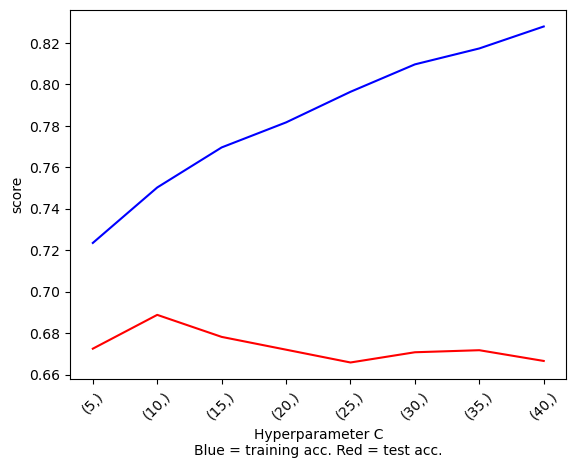

In [761]:
train_result = result_set_cv_model_1['mean_train_score']
test_result = result_set_cv_model_1['mean_test_score']
print("Total number of models: ", len(test_result))
# plot Hyperparameter C values vs training and test accuracy score
plt.plot(range(0, len(train_result)), train_result, 'b', range(0,len(test_result)), test_result, 'r')
plt.xlabel('Hyperparameter C\nBlue = training acc. Red = test acc.')
plt.xticks(range(0, len(train_result)),[(x,) for x in range(5, 45, 5)], rotation=45)
plt.ylabel('score')
plt.show()

In [763]:
print("Train accuracy:", cv_model_1.score(X_train, y_train))
print("Test accuracy:", cv_model_1.score(X_test, y_test))

y_pred_cv_model_1 = cv_model_1.predict(X_test)
print(classification_report(y_test, y_pred_cv_model_1))

print(cv_model_1.best_params_)

Train accuracy: 0.748025666337611
Test accuracy: 0.7006332757628094
              precision    recall  f1-score   support

           0       0.73      0.78      0.76      1036
           1       0.64      0.58      0.61       701

    accuracy                           0.70      1737
   macro avg       0.69      0.68      0.68      1737
weighted avg       0.70      0.70      0.70      1737

{'hidden_layer_sizes': (10,)}


In [765]:
# new parameters
params = {'hidden_layer_sizes': [(4,), (6,), (8,), (12,), (14,), (16,),]}

cv_model_2 = GridSearchCV(param_grid=params, estimator=MLPClassifier(random_state=rs),return_train_score=True, cv=10, n_jobs=-1)
cv_model_2.fit(X_train, y_train)

print("Train accuracy:", cv_model_2.score(X_train, y_train))
print("Test accuracy:", cv_model_2.score(X_test, y_test))

y_pred_cv_model_2 = cv_model_2.predict(X_test)
print(classification_report(y_test, y_pred_cv_model_2))

print(cv_model_2.best_params_)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_

Train accuracy: 0.7322309970384995
Test accuracy: 0.7023603914795624
              precision    recall  f1-score   support

           0       0.73      0.80      0.76      1036
           1       0.66      0.55      0.60       701

    accuracy                           0.70      1737
   macro avg       0.69      0.68      0.68      1737
weighted avg       0.70      0.70      0.70      1737

{'hidden_layer_sizes': (6,)}


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [767]:
result_set_cv_model_2 = cv_model_2.cv_results_
print(result_set_cv_model_2)

{'mean_fit_time': array([0.61570637, 0.59233198, 0.63742862, 0.85366633, 0.93253541,
       0.68669693]), 'std_fit_time': array([0.05706618, 0.02842134, 0.03463086, 0.10023902, 0.12502287,
       0.09139808]), 'mean_score_time': array([0.0008425 , 0.00058165, 0.00049386, 0.00041416, 0.00050812,
       0.0004801 ]), 'std_score_time': array([3.75396955e-04, 2.06991962e-04, 2.12180566e-04, 3.25987954e-05,
       2.18514856e-04, 1.77970296e-04]), 'param_hidden_layer_sizes': masked_array(data=[(4,), (6,), (8,), (12,), (14,), (16,)],
             mask=[False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'hidden_layer_sizes': (4,)}, {'hidden_layer_sizes': (6,)}, {'hidden_layer_sizes': (8,)}, {'hidden_layer_sizes': (12,)}, {'hidden_layer_sizes': (14,)}, {'hidden_layer_sizes': (16,)}], 'split0_test_score': array([0.64039409, 0.65270936, 0.6453202 , 0.66502463, 0.63546798,
       0.65763547]), 'split1_test_score': array([0.64039409, 0.63793103

Total number of models:  6


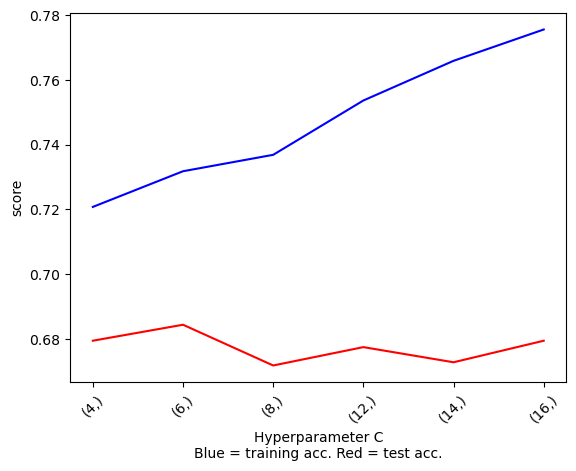

In [769]:
train_result = result_set_cv_model_2['mean_train_score']
test_result = result_set_cv_model_2['mean_test_score']
print("Total number of models: ", len(test_result))
# plot Hyperparameter C values vs training and test accuracy score
plt.plot(range(0, len(train_result)), train_result, 'b', range(0,len(test_result)), test_result, 'r')
plt.xlabel('Hyperparameter C\nBlue = training acc. Red = test acc.')
plt.xticks(range(0, len(train_result)),[(4,), (6,), (8,), (12,), (14,), (16,),], rotation=45)
plt.ylabel('score')
plt.show()

In [771]:
params = {'hidden_layer_sizes': [(4,), (6,), (8,), (12,), (14,), (16,),], 'alpha': [0.01, 0.001, 0.0001, 0.00001]}

cv_model_3 = GridSearchCV(param_grid=params, estimator=MLPClassifier(random_state=rs), return_train_score=True, cv=10, n_jobs=-1)
cv_model_3.fit(X_train, y_train)

print("Train accuracy:", cv_model_3.score(X_train, y_train))
print("Test accuracy:", cv_model_3.score(X_test, y_test))

y_pred_cv_model_3 = cv_model_3.predict(X_test)
print(classification_report(y_test, y_pred_cv_model_3))

print(cv_model_3.best_params_)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_

Train accuracy: 0.7319842053307009
Test accuracy: 0.7000575705238917
              precision    recall  f1-score   support

           0       0.72      0.80      0.76      1036
           1       0.65      0.55      0.60       701

    accuracy                           0.70      1737
   macro avg       0.69      0.68      0.68      1737
weighted avg       0.70      0.70      0.69      1737

{'alpha': 1e-05, 'hidden_layer_sizes': (6,)}


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [773]:
result_set_cv_model_3 = cv_model_3.cv_results_
print(result_set_cv_model_3)

{'mean_fit_time': array([0.61591053, 0.64679258, 0.70431933, 0.75872118, 0.75464718,
       0.77251098, 0.59356339, 0.66447756, 0.67461631, 0.77345519,
       0.80629051, 0.8036891 , 0.67495039, 0.73311126, 0.71442783,
       0.76865938, 0.81633959, 0.74588952, 0.58630681, 0.68339467,
       0.62836635, 0.72151701, 0.78607144, 0.64188871]), 'std_fit_time': array([0.0325152 , 0.0605912 , 0.06162115, 0.05789842, 0.03645478,
       0.0541612 , 0.04141311, 0.02449402, 0.05558122, 0.08844037,
       0.04245093, 0.07270945, 0.02817656, 0.06465425, 0.06507986,
       0.03335367, 0.08923008, 0.07304808, 0.04025124, 0.03797962,
       0.03601465, 0.05667622, 0.10037195, 0.11684311]), 'mean_score_time': array([0.0007375 , 0.00044017, 0.0010478 , 0.00138524, 0.00049112,
       0.00054238, 0.00067251, 0.00072322, 0.00059853, 0.00076666,
       0.0006613 , 0.00053518, 0.00067031, 0.0010834 , 0.0006398 ,
       0.00060825, 0.00042219, 0.00064583, 0.00065281, 0.00053923,
       0.00041766, 0.00101056

Total number of models:  24


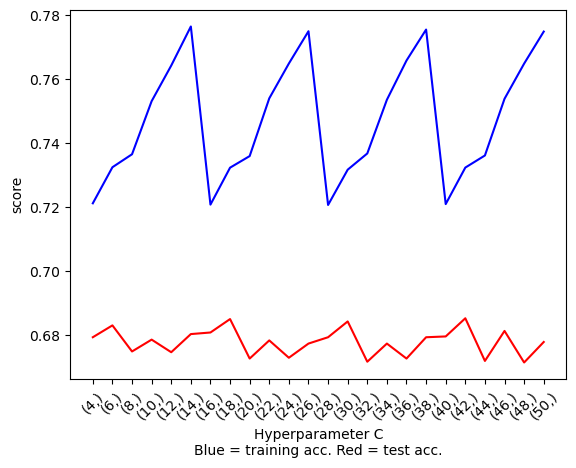

In [777]:
train_result = result_set_cv_model_3['mean_train_score']
test_result = result_set_cv_model_3['mean_test_score']
print("Total number of models: ", len(test_result))
# plot Hyperparameter C values vs training and test accuracy score
plt.plot(range(0, len(train_result)), train_result, 'b', range(0,len(test_result)), test_result, 'r')
plt.xlabel('Hyperparameter C\nBlue = training acc. Red = test acc.')
plt.xticks(range(0, len(train_result)),[(x,) for x in range(4, 52, 2)], rotation=45)
plt.ylabel('score')
plt.show()

previous model cv_model_2 remains better

In [779]:
# tuning 'max_iter'

params = {'hidden_layer_sizes': [(4,), (6,), (8,), (12,), (14,), (16,),], 'alpha': [0.01, 0.001, 0.0001, 0.00001], 'max_iter': [500, 600, 700]}

cv_model_4 = GridSearchCV(param_grid=params, estimator=MLPClassifier(random_state=rs), return_train_score=True, cv=10, n_jobs=-1)
cv_model_4.fit(X_train, y_train)

print("Train accuracy:", cv_model_4.score(X_train, y_train))
print("Test accuracy:", cv_model_4.score(X_test, y_test))

y_pred_cv_model_4 = cv_model_4.predict(X_test)
print(classification_report(y_test, y_pred_cv_model_4))

print(cv_model_4.best_params_)


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_

Train accuracy: 0.7203849950641659
Test accuracy: 0.7058146229130685
              precision    recall  f1-score   support

           0       0.73      0.80      0.76      1036
           1       0.66      0.56      0.61       701

    accuracy                           0.71      1737
   macro avg       0.69      0.68      0.69      1737
weighted avg       0.70      0.71      0.70      1737

{'alpha': 0.0001, 'hidden_layer_sizes': (4,), 'max_iter': 500}


In [783]:
result_set_cv_model_4 = cv_model_4.cv_results_
print(result_set_cv_model_4)

{'mean_fit_time': array([0.81306789, 0.76733818, 0.77740409, 1.0004837 , 0.93044832,
       1.03345597, 1.23450918, 1.24418123, 1.20795593, 1.65424039,
       1.67307436, 1.7142556 , 1.8252811 , 2.07389631, 2.09535077,
       1.81111176, 1.98637359, 1.98364758, 0.78749599, 0.83263552,
       0.74814653, 0.95997186, 1.04152069, 0.99309423, 1.3775084 ,
       1.44315526, 1.46493304, 1.93499377, 2.01453745, 2.02649601,
       1.73232274, 2.02218733, 2.16130371, 1.94361019, 2.03178217,
       2.2529566 , 0.79950545, 0.78380084, 0.74353259, 1.12645495,
       1.17808754, 1.14722912, 1.38646169, 1.44502997, 1.40084288,
       1.66645751, 1.53880734, 1.52402496, 1.78256197, 2.01392756,
       1.92999561, 1.7235322 , 2.02945218, 2.44039717, 0.87530007,
       0.80501158, 0.71648867, 1.07882605, 1.06324489, 1.14471688,
       1.29980569, 1.27034032, 1.31833673, 1.81865339, 1.88092289,
       1.77233229, 1.81651294, 1.97321057, 1.86782422, 1.8558167 ,
       2.06791797, 1.77055323]), 'std_fit_ti

Total number of models:  72


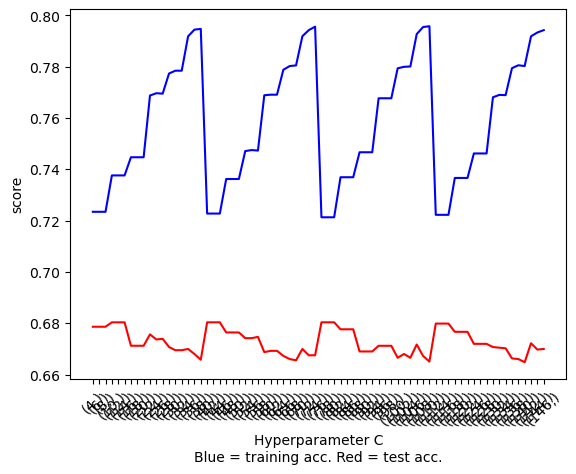

In [787]:
train_result = result_set_cv_model_4['mean_train_score']
test_result = result_set_cv_model_4['mean_test_score']
print("Total number of models: ", len(test_result))
# plot Hyperparameter C values vs training and test accuracy score
plt.plot(range(0, len(train_result)), train_result, 'b', range(0,len(test_result)), test_result, 'r')
plt.xlabel('Hyperparameter C\nBlue = training acc. Red = test acc.')
plt.xticks(range(0, len(train_result)),[(x,) for x in range(4, 148, 2)], rotation=45)
plt.ylabel('score')
plt.show()

In [729]:
rfe_nn_1 = RFECV(estimator = LogisticRegression(random_state=rs), cv=10)
rfe_nn_1.fit(X_train, y_train)

print(rfe_nn_1.n_features_)

32


In [789]:
X_train_rfe_nn_1 = rfe_nn_1.transform(X_train)
X_test_rfe_nn_1 = rfe_nn_1.transform(X_test)

# step = int((X_train_rfe.shape[1] + 5)/5);
params = {'hidden_layer_sizes': [(4,), (6,), (8,), (12,), (14,), (16,),], 'alpha': [0.01, 0.001, 0.0001, 0.00001], 'max_iter': [500, 600, 700]}

rfe_cv_nn_1 = GridSearchCV(param_grid=params, estimator=MLPClassifier(random_state=rs), return_train_score=True, cv=10, n_jobs=-1)
rfe_cv_nn_1.fit(X_train_rfe_nn_1, y_train)

print("Train accuracy:", rfe_cv_nn_1.score(X_train_rfe_nn_1, y_train))
print("Test accuracy:", rfe_cv_nn_1.score(X_test_rfe_nn_1, y_test))

y_pred_rfe_cv_nn_1 = rfe_cv_nn_1.predict(X_test_rfe)
print(classification_report(y_test, y_pred_rfe_cv_nn_1))

print(rfe_cv_nn_1.best_params_)


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_

Train accuracy: 0.7268015794669299
Test accuracy: 0.7023603914795624
              precision    recall  f1-score   support

           0       0.74      0.78      0.76      1036
           1       0.64      0.59      0.61       701

    accuracy                           0.70      1737
   macro avg       0.69      0.68      0.69      1737
weighted avg       0.70      0.70      0.70      1737

{'alpha': 0.01, 'hidden_layer_sizes': (8,), 'max_iter': 600}


In [791]:
result_set_rfe_cv_nn_1 = rfe_cv_nn_1.cv_results_
print(result_set_rfe_cv_nn_1)

{'mean_fit_time': array([0.91328311, 0.85351341, 0.80311298, 0.79957514, 0.85553284,
       0.82687433, 1.10823133, 1.16934152, 1.09538109, 1.57662799,
       1.57837787, 1.64462588, 1.61165307, 1.99358308, 1.6654568 ,
       1.48783641, 1.52932985, 1.58783019, 0.90292115, 0.8930994 ,
       0.90545223, 0.87517712, 0.86755531, 0.85612266, 1.10371482,
       1.14647968, 1.1890348 , 1.48769996, 1.58144789, 1.61053417,
       1.49327917, 1.53913314, 1.4992928 , 1.62811162, 1.72793441,
       1.69785285, 0.87402847, 0.82147696, 0.87654057, 0.80003853,
       0.74507787, 0.77155664, 1.19178791, 1.09455657, 1.11086462,
       1.45050888, 1.60697999, 1.74743423, 1.45797803, 1.45777013,
       1.62453182, 1.85352948, 1.82937243, 1.83032854, 0.94956813,
       0.90912216, 0.95926838, 0.84915881, 0.81383905, 0.88017409,
       1.20925012, 1.22422614, 1.19078813, 1.49895599, 1.69740951,
       1.77978666, 1.45633047, 1.51636877, 1.49415417, 1.50646353,
       1.69033644, 1.5043997 ]), 'std_fit_ti

Total number of models:  72


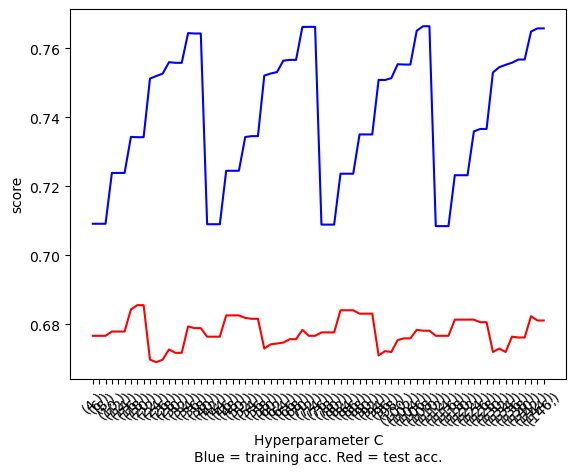

In [793]:
train_result = result_set_rfe_cv_nn_1['mean_train_score']
test_result = result_set_rfe_cv_nn_1['mean_test_score']
print("Total number of models: ", len(test_result))
# plot Hyperparameter C values vs training and test accuracy score
plt.plot(range(0, len(train_result)), train_result, 'b', range(0,len(test_result)), test_result, 'r')
plt.xlabel('Hyperparameter C\nBlue = training acc. Red = test acc.')
plt.xticks(range(0, len(train_result)),[(x,) for x in range(4, 148, 2)], rotation=45)
plt.ylabel('score')
plt.show()

This performs better without 'max_iter'.

In [795]:
X_train_rfe_nn_1 = rfe_nn_1.transform(X_train)
X_test_rfe_nn_1 = rfe_nn_1.transform(X_test)

# step = int((X_train_rfe.shape[1] + 5)/5);
params = {'hidden_layer_sizes': [(4,), (6,), (8,), (12,), (14,), (16,),], 'alpha': [0.01, 0.001, 0.0001, 0.00001]}

rfe_cv_nn_1 = GridSearchCV(param_grid=params, estimator=MLPClassifier(random_state=rs), return_train_score=True, cv=10, n_jobs=-1)
rfe_cv_nn_1.fit(X_train_rfe_nn_1, y_train)

print("Train accuracy:", rfe_cv_nn_1.score(X_train_rfe_nn_1, y_train))
print("Test accuracy:", rfe_cv_nn_1.score(X_test_rfe_nn_1, y_test))

y_pred_rfe_cv_nn_1 = rfe_cv_nn_1.predict(X_test_rfe)
print(classification_report(y_test, y_pred_rfe_cv_nn_1))

print(rfe_cv_nn_1.best_params_)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_

Train accuracy: 0.7532082922013821
Test accuracy: 0.7040875071963155
              precision    recall  f1-score   support

           0       0.74      0.78      0.76      1036
           1       0.65      0.58      0.61       701

    accuracy                           0.70      1737
   macro avg       0.69      0.68      0.69      1737
weighted avg       0.70      0.70      0.70      1737

{'alpha': 1e-05, 'hidden_layer_sizes': (16,)}


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [797]:
result_set_rfe_cv_nn_1 = rfe_cv_nn_1.cv_results_
print(result_set_rfe_cv_nn_1)

{'mean_fit_time': array([0.58115108, 0.60453126, 0.54463041, 0.61527839, 0.74019828,
       0.73194726, 0.59992557, 0.63483658, 0.62211049, 0.67409918,
       0.65882902, 0.64013972, 0.5425024 , 0.62306862, 0.58732791,
       0.71257899, 0.72417221, 0.74256332, 0.55777197, 0.61851926,
       0.58723049, 0.66302299, 0.75356395, 0.66266887]), 'std_fit_time': array([0.05145369, 0.02443547, 0.04691866, 0.03984323, 0.02430039,
       0.02958927, 0.06559748, 0.0246512 , 0.06430701, 0.02722934,
       0.038024  , 0.02744667, 0.03542197, 0.04846612, 0.04125564,
       0.03141274, 0.03923122, 0.07918746, 0.05602214, 0.04930712,
       0.04988259, 0.05730788, 0.06726554, 0.08740792]), 'mean_score_time': array([0.00059092, 0.00077147, 0.00039289, 0.00039501, 0.00074904,
       0.00085795, 0.00046406, 0.00057664, 0.00051286, 0.00080106,
       0.0004873 , 0.00049915, 0.00050571, 0.00084317, 0.0006367 ,
       0.00042901, 0.00109539, 0.00054247, 0.00067272, 0.00089173,
       0.00048723, 0.00060418

Total number of models:  24


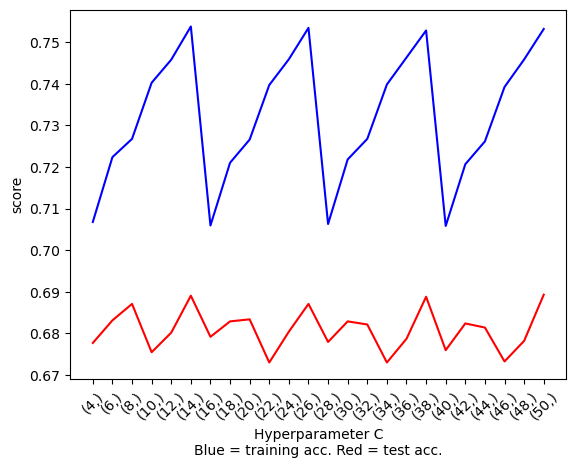

In [805]:
train_result = result_set_rfe_cv_nn_1['mean_train_score']
test_result = result_set_rfe_cv_nn_1['mean_test_score']
print("Total number of models: ", len(test_result))
# plot Hyperparameter C values vs training and test accuracy score
plt.plot(range(0, len(train_result)), train_result, 'b', range(0,len(test_result)), test_result, 'r')
plt.xlabel('Hyperparameter C\nBlue = training acc. Red = test acc.')
plt.xticks(range(0, len(train_result)),[(x,) for x in range(4, 52, 2)], rotation=45)
plt.ylabel('score')
plt.show()

In [807]:
params = {'hidden_layer_sizes': [(3,), (5,), (7,), (9,)], 'alpha': [0.01,0.001, 0.0001, 0.00001]}

cv_selected_features_nn_model = GridSearchCV(param_grid=params, estimator=MLPClassifier(random_state=rs), return_train_score=True, cv=10, n_jobs=-1)
cv_selected_features_nn_model.fit(X_train_selected_features_model, y_train)

print("Train accuracy:", cv_selected_features_nn_model.score(X_train_selected_features_model, y_train))
print("Test accuracy:", cv_selected_features_nn_model.score(X_test_selected_features_model, y_test))

y_pred_selected_features_nn_model = cv_selected_features_nn_model.predict(X_test_selected_features_model)
print(classification_report(y_test, y_pred_selected_features_nn_model))

print(cv_selected_features_nn_model.best_params_)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_

Train accuracy: 0.6971865745310958
Test accuracy: 0.7000575705238917
              precision    recall  f1-score   support

           0       0.76      0.73      0.74      1036
           1       0.62      0.65      0.64       701

    accuracy                           0.70      1737
   macro avg       0.69      0.69      0.69      1737
weighted avg       0.70      0.70      0.70      1737

{'alpha': 0.01, 'hidden_layer_sizes': (9,)}


In [809]:
result_set_selected_features_nn_model = cv_selected_features_nn_model.cv_results_
print(result_set_selected_features_nn_model)

{'mean_fit_time': array([0.4066469 , 0.33239322, 0.48319318, 0.48547184, 0.41392684,
       0.29630246, 0.51212859, 0.51004717, 0.38780184, 0.3171587 ,
       0.44871998, 0.48797538, 0.40589068, 0.33880553, 0.49131753,
       0.41841998]), 'std_fit_time': array([0.07632346, 0.04525571, 0.05301075, 0.04229391, 0.06971183,
       0.03386647, 0.05462825, 0.03648414, 0.08055385, 0.0510859 ,
       0.05092818, 0.06618442, 0.08305971, 0.02171237, 0.05056499,
       0.04780944]), 'mean_score_time': array([0.00053377, 0.00046084, 0.00043092, 0.00054073, 0.00058589,
       0.00046797, 0.0003834 , 0.0004499 , 0.00046566, 0.00046914,
       0.00068932, 0.00045936, 0.00052404, 0.00047803, 0.00053213,
       0.00034604]), 'std_score_time': array([1.67344498e-04, 1.60683880e-04, 1.44232805e-04, 1.91350688e-04,
       2.15463639e-04, 1.64398274e-04, 2.67913855e-05, 1.54774430e-04,
       1.78630081e-04, 2.06397025e-04, 6.09542329e-04, 1.59543972e-04,
       1.86821427e-04, 1.33968416e-04, 1.79100552e

Total number of models:  16


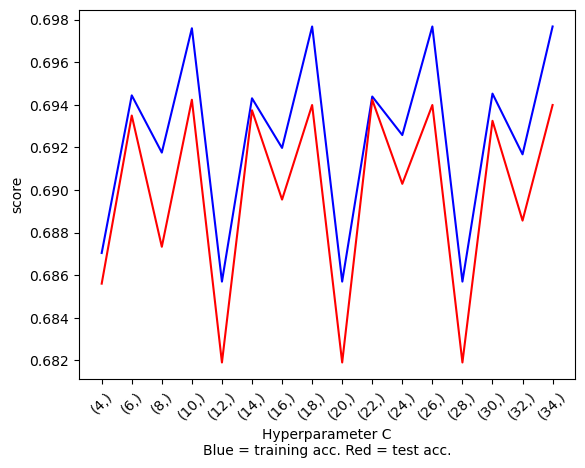

In [817]:
train_result = result_set_selected_features_nn_model['mean_train_score']
test_result = result_set_selected_features_nn_model['mean_test_score']
print("Total number of models: ", len(test_result))
# plot Hyperparameter C values vs training and test accuracy score
plt.plot(range(0, len(train_result)), train_result, 'b', range(0,len(test_result)), test_result, 'r')
plt.xlabel('Hyperparameter C\nBlue = training acc. Red = test acc.')
plt.xticks(range(0, len(train_result)),[(x,) for x in range(4, 36, 2)], rotation=45)
plt.ylabel('score')
plt.show()

In [823]:
## tuning max_iter

params = {'hidden_layer_sizes': [(3,), (5,), (7,), (9,)], 'alpha': [0.01,0.001, 0.0001, 0.00001], 'max_iter':[300, 400, 500]}

cv_selected_features_nn_model = GridSearchCV(param_grid=params, estimator=MLPClassifier(random_state=rs),return_train_score=True, cv=10, n_jobs=-1)
cv_selected_features_nn_model.fit(X_train_selected_features_model, y_train)

print("Train accuracy:", cv_selected_features_nn_model.score(X_train_selected_features_model, y_train))
print("Test accuracy:", cv_selected_features_nn_model.score(X_test_selected_features_model, y_test))

y_pred_selected_features_nn_model = cv_selected_features_nn_model.predict(X_test_selected_features_model)
print(classification_report(y_test, y_pred_selected_features_nn_model))

print(cv_selected_features_nn_model.best_params_)

Train accuracy: 0.6971865745310958
Test accuracy: 0.7000575705238917
              precision    recall  f1-score   support

           0       0.76      0.73      0.74      1036
           1       0.62      0.65      0.64       701

    accuracy                           0.70      1737
   macro avg       0.69      0.69      0.69      1737
weighted avg       0.70      0.70      0.70      1737

{'alpha': 1e-05, 'hidden_layer_sizes': (9,), 'max_iter': 300}


In [825]:
result_set_selected_features_nn_model = cv_selected_features_nn_model.cv_results_
print(result_set_selected_features_nn_model)

{'mean_fit_time': array([0.44736526, 0.42688639, 0.42916853, 0.32441204, 0.30931404,
       0.33562379, 0.46011043, 0.45346775, 0.44283502, 0.52787738,
       0.53395119, 0.50796528, 0.40016894, 0.43080134, 0.41593335,
       0.27940226, 0.2977232 , 0.28975763, 0.48793259, 0.46976345,
       0.46813226, 0.50576463, 0.51477921, 0.50945957, 0.40220993,
       0.40305979, 0.40284884, 0.30893536, 0.31716902, 0.32159259,
       0.44971337, 0.51666191, 0.4515636 , 0.54297616, 0.54863129,
       0.50879517, 0.40671475, 0.38634052, 0.40661168, 0.3046432 ,
       0.31372085, 0.31750379, 0.50690975, 0.49515538, 0.50086553,
       0.60385902, 0.52938912, 0.45166886]), 'std_fit_time': array([0.06771205, 0.05674418, 0.08875702, 0.03276739, 0.03158445,
       0.06305689, 0.05716413, 0.04863894, 0.04117177, 0.05602367,
       0.08078659, 0.05009281, 0.1155668 , 0.1196754 , 0.10137214,
       0.0174604 , 0.02750991, 0.01689639, 0.08189708, 0.06072422,
       0.07945269, 0.04201445, 0.05196585, 0.04924

Total number of models:  48


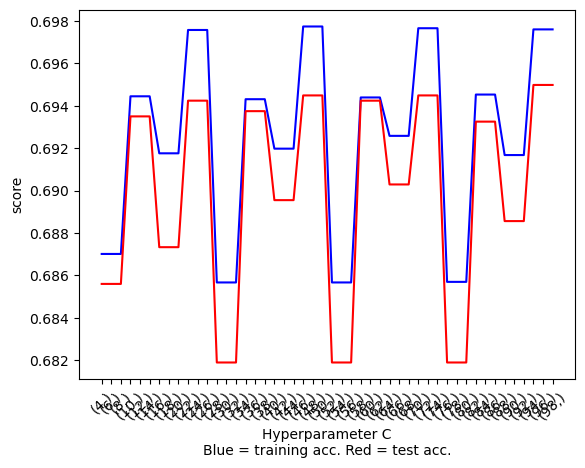

In [829]:
train_result = result_set_selected_features_nn_model['mean_train_score']
test_result = result_set_selected_features_nn_model['mean_test_score']
print("Total number of models: ", len(test_result))
# plot Hyperparameter C values vs training and test accuracy score
plt.plot(range(0, len(train_result)), train_result, 'b', range(0,len(test_result)), test_result, 'r')
plt.xlabel('Hyperparameter C\nBlue = training acc. Red = test acc.')
plt.xticks(range(0, len(train_result)),[(x,) for x in range(4, 100, 2)], rotation=45)
plt.ylabel('score')
plt.show()

This is now converging.

In [744]:
best_model = rfe_cv_nn_1.best_estimator_  # Get the best model
weights = best_model.coefs_  # List of weight matrices

# Example: weights[0] contains the weights between the input layer and the first hidden layer
print("Weights between input and first hidden layer:", weights[0])

Weights between input and first hidden layer: [[ 0.31695171 -0.16157832  0.03195518 -0.05741725  0.59149197 -0.75264764
   0.29291294  0.09327754 -0.37648933  0.11977554 -0.31277881  0.30490998
   0.28350811 -0.05164607 -0.13203027  0.03121684]
 [-0.08120401 -0.49277413 -0.33223269 -0.03426314  0.06118408  0.24908885
   0.23227268 -0.10494044  0.1970687  -0.22239323 -0.28933173 -0.04087159
  -0.47059157  0.1690481  -0.03640235  0.03018697]
 [ 0.03447617 -0.34161048 -0.21872976 -0.14294331 -0.23972585  0.00256844
  -0.44261563  0.42700839  0.41427109  0.34759284 -0.03521021 -0.07042681
  -0.15235497 -0.32613386  0.54757545 -0.01499833]
 [ 0.03252544 -0.14304419 -0.43405595 -0.06756337 -0.12840477 -0.58826823
   0.2386942   0.19300011 -0.04932271  0.008932   -0.24187137  0.03989603
  -0.04543934 -0.0103353   0.24043763 -0.03536617]
 [ 0.33139517 -0.32573619  0.45564803 -0.34191235  0.2781108  -0.06807231
  -0.47618425  0.10846949  0.96756214 -0.38869718  0.32808446  0.02699509
  -0.03885

In [748]:
import numpy as np

# Sum the absolute weights for each input feature
input_weights = np.sum(np.abs(weights[0]), axis=1)

# Map to feature names
feature_names = X.columns  # Assuming X is a DataFrame
feature_importance = sorted(
    zip(feature_names, input_weights),
    key=lambda x: x[1],
    reverse=True
)

print("Feature importance:", '\t', feature_importance)

Feature importance: 	 [('contacts_count', 6.360312421773421), ('smoking_never', 4.9199120009527935), ('age_0_10', 4.813758836678143), ('age_40_50', 4.387861759007465), ('age_60_70', 4.176566401043816), ('age_70_80', 4.169100623940956), ('height', 3.9105875045382517), ('blood_type_abn', 3.8503374510143358), ('income_gov', 3.8008113388025535), ('blood_type_abp', 3.763315509350938), ('insurance', 3.7582415978812542), ('age_20_30', 3.728983430342602), ('blood_type_unknown', 3.5924927718572457), ('blood_type_bn', 3.512667381774999), ('gender_female', 3.3724190968409165), ('blood_type_an', 3.3677133073633883), ('income_med', 3.317385277713913), ('income_low', 3.2926508922380333), ('income_high', 3.241886861792721), ('blood_type_ap', 3.1229987620244835), ('weight', 3.043854289480673), ('gender_male', 3.005207099300279), ('blood_type_op', 2.9885558655790634), ('worried', 2.7791204260968256), ('age_30_40', 2.7633718362220723), ('blood_type_bp', 2.6951347722029215), ('age_100_110', 2.52501155238

Now we will look at the ROC curve for all these models.

In [834]:
y_pred_proba_nn_model_1 = model_1.predict_proba(X_test)
y_pred_proba_nn_cv_model_1 = cv_model_1.predict_proba(X_test)
y_pred_proba_nn_cv_model_2 = cv_model_2.predict_proba(X_test)
y_pred_proba_nn_cv_model_3 = cv_model_3.predict_proba(X_test)
y_pred_proba_nn_cv_model_4 = cv_model_4.predict_proba(X_test)
y_pred_proba_rfe_cv_nn_1 = rfe_cv_nn_1.predict_proba(X_test_rfe)
y_pred_proba_cv_selected_features_nn_model = cv_selected_features_nn_model.predict_proba(X_test_selected_features_model)

roc_index_model_1 = roc_auc_score(y_test, y_pred_proba_nn_model_1[:, 1])
roc_index_cv_model_1 = roc_auc_score(y_test, y_pred_proba_nn_cv_model_1[:, 1])
roc_index_cv_model_2 = roc_auc_score(y_test, y_pred_proba_nn_cv_model_2[:, 1])
roc_index_cv_model_3 = roc_auc_score(y_test, y_pred_proba_nn_cv_model_3[:, 1])
roc_index_cv_model_4 = roc_auc_score(y_test, y_pred_proba_nn_cv_model_4[:, 1])
roc_index_rfe_cv_nn_1 = roc_auc_score(y_test, y_pred_proba_rfe_cv_nn_1[:, 1])
roc_index_cv_selected_features_nn_model = roc_auc_score(y_test, y_pred_proba_cv_selected_features_nn_model[:, 1])

print("ROC index on test for default neural network:", roc_index_model_1)
print("ROC index on test for neural network with optimal hidden_layer_sizes:", roc_index_cv_model_1)
print("ROC index on test for neural network with further granularity for optimal hidden_layer_sizes", roc_index_cv_model_2)
print("ROC index on test for neural network with further granularity for optimal hidden_layer_sizes and optimal alpha:", roc_index_cv_model_3)
print("ROC index on test for neural network with further granularity for optimal hidden_layer_sizes, optimal alpha and optimal max_iter:", roc_index_cv_model_4)
print("ROC index on test for neural network with dimensionality reduction via RFE, further granularity for optimal hidden_layer_sizes and optimal alpha:", roc_index_rfe_cv_nn_1)
print("ROC index on test for neural network with selected features from decision tree, further granularity for optimal hidden_layer_sizes and optimal alpha:", roc_index_selected_features)

## ROC scores

fpr_neural_network_default, tpr_neural_network_default, thresholds_neural_network_default = roc_curve(y_test, y_pred_proba_nn_model_1[:,1])
fpr_cv_model_1, tpr_cv_model_1, thresholds_cv_model_1 = roc_curve(y_test, y_pred_proba_nn_cv_model_1[:,1])
fpr_cv_model_2, tpr_cv_model_2, thresholds_cv_model_2 = roc_curve(y_test, y_pred_proba_nn_cv_model_2[:,1])
fpr_cv_model_3, tpr_cv_model_3, thresholds_cv_model_3 = roc_curve(y_test, y_pred_proba_nn_cv_model_3[:,1])
fpr_cv_model_4, tpr_cv_model_4, thresholds_cv_model_4 = roc_curve(y_test, y_pred_proba_nn_cv_model_4[:,1])
fpr_rfe_cv_nn_1, tpr_rfe_cv_nn_1, thresholds_rfe_cv_nn_1 = roc_curve(y_test, y_pred_proba_rfe_cv_nn_1[:,1])
fpr_cv_selected_features_nn_model, tpr_cv_selected_features_nn_model, thresholds_cv_selected_features_nn_model = roc_curve(y_test, y_pred_proba_cv_selected_features_nn_model[:,1])


ROC index on test for default neural network: 0.7092184909588617
ROC index on test for neural network with optimal hidden_layer_sizes: 0.7497686702394263
ROC index on test for neural network with further granularity for optimal hidden_layer_sizes 0.7555925346581551
ROC index on test for neural network with further granularity for optimal hidden_layer_sizes and optimal alpha: 0.7545088648868963
ROC index on test for neural network with further granularity for optimal hidden_layer_sizes, optimal alpha and optimal max_iter: 0.7494092829328207
ROC index on test for neural network with dimensionality reduction via RFE, further granularity for optimal hidden_layer_sizes and optimal alpha: 0.7445527349236337
ROC index on test for neural network with selected features from decision tree, further granularity for optimal hidden_layer_sizes and optimal alpha: 0.7117438408451247


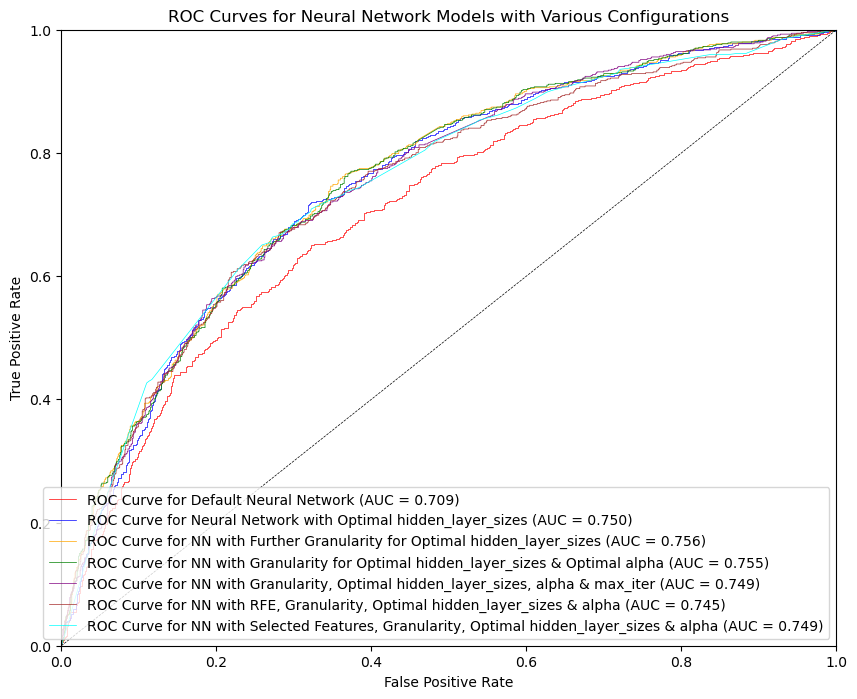

In [844]:
plt.figure(figsize=(10, 8))

# Plot ROC curves for each model
plt.plot(fpr_neural_network_default, tpr_neural_network_default, 
         label='ROC Curve for Default Neural Network (AUC = {:.3f})'.format(roc_index_model_1), color='red', lw=0.5)
plt.plot(fpr_cv_model_1, tpr_cv_model_1, 
         label='ROC Curve for Neural Network with Optimal hidden_layer_sizes (AUC = {:.3f})'.format(roc_index_cv_model_1), color='blue', lw=0.5)
plt.plot(fpr_cv_model_2, tpr_cv_model_2, 
         label='ROC Curve for NN with Further Granularity for Optimal hidden_layer_sizes (AUC = {:.3f})'.format(roc_index_cv_model_2), color='orange', lw=0.5)
plt.plot(fpr_cv_model_3, tpr_cv_model_3, 
         label='ROC Curve for NN with Granularity for Optimal hidden_layer_sizes & Optimal alpha (AUC = {:.3f})'.format(roc_index_cv_model_3), color='green', lw=0.5)
plt.plot(fpr_cv_model_4, tpr_cv_model_4, 
         label='ROC Curve for NN with Granularity, Optimal hidden_layer_sizes, alpha & max_iter (AUC = {:.3f})'.format(roc_index_cv_model_4), color='purple', lw=0.5)
plt.plot(fpr_rfe_cv_nn_1, tpr_rfe_cv_nn_1, 
         label='ROC Curve for NN with RFE, Granularity, Optimal hidden_layer_sizes & alpha (AUC = {:.3f})'.format(roc_index_rfe_cv_nn_1), color='brown', lw=0.5)
plt.plot(fpr_cv_selected_features_nn_model, tpr_cv_selected_features_nn_model, 
         label='ROC Curve for NN with Selected Features, Granularity, Optimal hidden_layer_sizes & alpha (AUC = {:.3f})'.format(roc_index_cv_selected_features_nn_model), color='cyan', lw=0.5)

# Add diagonal line for random chance
plt.plot([0, 1], [0, 1], color='black', lw=0.5, linestyle='--')

# Adjust plot details
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Neural Network Models with Various Configurations')
plt.legend(loc="lower right")

# Save and show plot
plt.savefig("nn_models_roc_curves.png", dpi=300)
plt.show()


In [842]:
best_model = cv_model_2.best_estimator_  # Get the best model
weights = best_model.coefs_  # List of weight matrices

# Example: weights[0] contains the weights between the input layer and the first hidden layer
print("Weights between input and first hidden layer:", weights[0])
# Sum the absolute weights for each input feature
input_weights = np.sum(np.abs(weights[0]), axis=1)

# Map to feature names
feature_names = X.columns  # Assuming X is a DataFrame
feature_importance = sorted(
    zip(feature_names, input_weights),
    key=lambda x: x[1],
    reverse=True
)

print("Feature importance:", '\t', feature_importance)

Weights between input and first hidden layer: [[-2.34877047e-01  1.42205526e-02  2.95637812e-01  1.07217525e-01
   6.14662892e-02 -2.10892994e-01]
 [ 7.11178225e-01 -2.53390551e-01 -2.13436470e-01 -3.16993892e-01
  -3.33128631e-02  8.07811267e-02]
 [-7.57222292e-02 -3.43271865e-03  1.32532853e-01  9.42806691e-01
   1.17832000e-01  4.27131981e-02]
 [ 2.79474555e-01  9.92121281e-02 -1.49653286e-01 -2.58445941e-01
   3.63922539e-01 -2.12903868e-01]
 [ 6.53802662e-01 -5.63979212e-02 -1.45281317e-01  1.30577927e-01
   5.71374070e-02 -8.09151441e-01]
 [ 1.27780587e-01 -2.26445157e-01  8.15208627e-01  6.20303293e-01
   1.08804640e-01 -2.76458492e-02]
 [-2.63335673e-01  2.93222940e-03 -9.44513856e-02 -4.43996877e-02
   3.55366212e-01  1.28439726e-01]
 [ 3.21644307e-01 -1.79916339e-01 -1.69200340e-01 -9.48436301e-02
  -1.77409813e-02  1.33143462e-01]
 [-1.64747506e-01  1.03095980e-01 -2.67597292e-01  2.27655595e-01
   5.34140441e-02 -2.02876195e-01]
 [-5.73759750e-02  4.00379127e-02  9.59598163

In [850]:
from sklearn.inspection import permutation_importance

result = permutation_importance(cv_model_2, X_test, y_test, n_repeats=10, random_state=rs)
feature_importances = result.importances_mean

# Rank features by importance
sorted_idx = feature_importances.argsort()
for idx in sorted_idx[::-1]:
    print(f"Feature: {X.columns[idx]}, Importance: {feature_importances[idx]}")

Feature: income_med, Importance: 0.04242947610823254
Feature: weight, Importance: 0.023028209556706904
Feature: worried, Importance: 0.021013241220495072
Feature: height, Importance: 0.015486470926885399
Feature: working_never, Importance: 0.015371329879101859
Feature: income_high, Importance: 0.013413932066781754
Feature: insurance, Importance: 0.01151410477835343
Feature: smoking_never, Importance: 0.010477835348301623
Feature: age_70_80, Importance: 0.008059873344847378
Feature: gender_male, Importance: 0.007656879677605022
Feature: age_60_70, Importance: 0.0060449050086355035
Feature: contacts_count, Importance: 0.005929763960852019
Feature: smoking_quit5, Importance: 0.005469199769717858
Feature: income_low, Importance: 0.005354058721934318
Feature: age_20_30, Importance: 0.00506620610247549
Feature: working_home, Importance: 0.004663212435233122
Feature: working_travel non critical, Importance: 0.004490500863557812
Feature: gender_female, Importance: 0.0038572251007483517
Feature

ROC index on test for default decision tree: 0.44429359051327666
ROC index on test for optimal decision tree: 0.7194603407156902
ROC index on test for default regression: 0.44429359051327666
ROC index on test for regression model with optimal C: 0.7447482636498328
ROC index on test for RFE regression model with optimal C: 0.7460963102903189
ROC index on test for regression model with optimal C and selected features from decision tree: 0.7117438408451247
ROC index on test for default neural network: 0.7092184909588617
ROC index on test for neural network with optimal hidden_layer_sizes: 0.7497686702394263
ROC index on test for neural network with further granularity for optimal hidden_layer_sizes 0.7555925346581551
ROC index on test for neural network with further granularity for optimal hidden_layer_sizes and optimal alpha: 0.7545088648868963
ROC index on test for neural network with further granularity for optimal hidden_layer_sizes, optimal alpha and optimal max_iter: 0.7494092829328

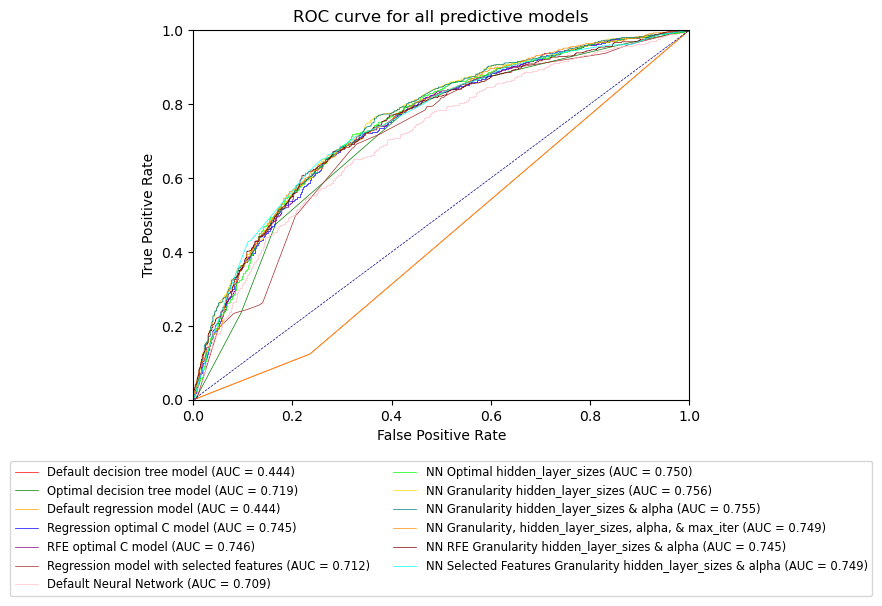

In [862]:
## full ROC curve

y_pred_proba = model.predict_proba(X_test)
y_pred_proba_regression = model.predict_proba(X_test)
y_pred_proba_regression_optimal_c = regression_optimal_c.predict_proba(X_test)
y_pred_proba_rfe_optimal_c = rfe_optimal_c.predict_proba(X_test_rfe)
y_pred_proba_regression_selected_features = cv_selected_features_model.predict_proba(X_test_selected_features_model)
y_pred_proba_nn_model_1 = model_1.predict_proba(X_test)
y_pred_proba_nn_cv_model_1 = cv_model_1.predict_proba(X_test)
y_pred_proba_nn_cv_model_2 = cv_model_2.predict_proba(X_test)
y_pred_proba_nn_cv_model_3 = cv_model_3.predict_proba(X_test)
y_pred_proba_nn_cv_model_4 = cv_model_4.predict_proba(X_test)
y_pred_proba_rfe_cv_nn_1 = rfe_cv_nn_1.predict_proba(X_test_rfe)
y_pred_proba_cv_selected_features_nn_model = cv_selected_features_nn_model.predict_proba(X_test_selected_features_model)

roc_index = roc_auc_score(y_test, y_pred_proba[:, 1])
roc_index_optimal = roc_auc_score(y_test, y_pred_proba_optimal[:, 1])
roc_index_regression = roc_auc_score(y_test, y_pred_proba_regression[:, 1])
roc_index_regression_optimal_c = roc_auc_score(y_test, y_pred_proba_regression_optimal_c[:, 1])
roc_index_rfe_optimal_c = roc_auc_score(y_test, y_pred_proba_rfe_optimal_c[:, 1])
roc_index_regression_selected_features = roc_auc_score(y_test, y_pred_proba_regression_selected_features[:, 1])
roc_index_model_1 = roc_auc_score(y_test, y_pred_proba_nn_model_1[:, 1])
roc_index_cv_model_1 = roc_auc_score(y_test, y_pred_proba_nn_cv_model_1[:, 1])
roc_index_cv_model_2 = roc_auc_score(y_test, y_pred_proba_nn_cv_model_2[:, 1])
roc_index_cv_model_3 = roc_auc_score(y_test, y_pred_proba_nn_cv_model_3[:, 1])
roc_index_cv_model_4 = roc_auc_score(y_test, y_pred_proba_nn_cv_model_4[:, 1])
roc_index_rfe_cv_nn_1 = roc_auc_score(y_test, y_pred_proba_rfe_cv_nn_1[:, 1])
roc_index_cv_selected_features_nn_model = roc_auc_score(y_test, y_pred_proba_cv_selected_features_nn_model[:, 1])

print("ROC index on test for default decision tree:", roc_index)
print("ROC index on test for optimal decision tree:", roc_index_optimal)
print("ROC index on test for default regression:", roc_index_regression)
print("ROC index on test for regression model with optimal C:", roc_index_regression_optimal_c)
print("ROC index on test for RFE regression model with optimal C:", roc_index_rfe_optimal_c)
print("ROC index on test for regression model with optimal C and selected features from decision tree:", roc_index_selected_features)
print("ROC index on test for default neural network:", roc_index_model_1)
print("ROC index on test for neural network with optimal hidden_layer_sizes:", roc_index_cv_model_1)
print("ROC index on test for neural network with further granularity for optimal hidden_layer_sizes", roc_index_cv_model_2)
print("ROC index on test for neural network with further granularity for optimal hidden_layer_sizes and optimal alpha:", roc_index_cv_model_3)
print("ROC index on test for neural network with further granularity for optimal hidden_layer_sizes, optimal alpha and optimal max_iter:", roc_index_cv_model_4)
print("ROC index on test for neural network with dimensionality reduction via RFE, further granularity for optimal hidden_layer_sizes and optimal alpha:", roc_index_rfe_cv_nn_1)
print("ROC index on test for neural network with selected features from decision tree, further granularity for optimal hidden_layer_sizes and optimal alpha:", roc_index_selected_features)

fpr_default, tpr_default, thresholds_default = roc_curve(y_test, y_pred_proba[:,1])
fpr_optimal, tpr_optimal, thresholds_optimal = roc_curve(y_test, y_pred_proba_optimal[:,1])
fpr_regression_default, tpr_regression_default, thresholds_regression_default = roc_curve(y_test, y_pred_proba_regression[:,1])
fpr_regression_optimal_c, tpr_regression_optimal_c, thresholds_regression_optimal_c = roc_curve(y_test, y_pred_proba_regression_optimal_c[:,1])
fpr_rfe_optimal_c, tpr_rfe_optimal_c, thresholds_rfe_optimal_c = roc_curve(y_test, y_pred_proba_rfe_optimal_c[:,1])
fpr_regression_selected_features, tpr_regression_selected_features, thresholds_regression_selected_features = roc_curve(y_test, y_pred_proba_regression_selected_features[:,1])
fpr_neural_network_default, tpr_neural_network_default, thresholds_neural_network_default = roc_curve(y_test, y_pred_proba_nn_model_1[:,1])
fpr_cv_model_1, tpr_cv_model_1, thresholds_cv_model_1 = roc_curve(y_test, y_pred_proba_nn_cv_model_1[:,1])
fpr_cv_model_2, tpr_cv_model_2, thresholds_cv_model_2 = roc_curve(y_test, y_pred_proba_nn_cv_model_2[:,1])
fpr_cv_model_3, tpr_cv_model_3, thresholds_cv_model_3 = roc_curve(y_test, y_pred_proba_nn_cv_model_3[:,1])
fpr_cv_model_4, tpr_cv_model_4, thresholds_cv_model_4 = roc_curve(y_test, y_pred_proba_nn_cv_model_4[:,1])
fpr_rfe_cv_nn_1, tpr_rfe_cv_nn_1, thresholds_rfe_cv_nn_1 = roc_curve(y_test, y_pred_proba_rfe_cv_nn_1[:,1])
fpr_cv_selected_features_nn_model, tpr_cv_selected_features_nn_model, thresholds_cv_selected_features_nn_model = roc_curve(y_test, y_pred_proba_cv_selected_features_nn_model[:,1])

plt.plot(fpr_default, tpr_default, label='Default decision tree model (AUC = {:.3f})'.format(roc_index), color='red', lw=0.5)
plt.plot(fpr_optimal, tpr_optimal, label='Optimal decision tree model (AUC = {:.3f})'.format(roc_index_optimal), color='green', lw=0.5)
plt.plot(fpr_regression_default, tpr_regression_default, label='Default regression model (AUC = {:.3f})'.format(roc_index), color='orange', lw=0.5)
plt.plot(fpr_regression_optimal_c, tpr_regression_optimal_c, label='Regression optimal C model (AUC = {:.3f})'.format(roc_index_regression_optimal_c), color='blue', lw=0.5)
plt.plot(fpr_rfe_optimal_c, tpr_rfe_optimal_c, label='RFE optimal C model (AUC = {:.3f})'.format(roc_index_rfe_optimal_c), color='purple', lw=0.5)
plt.plot(fpr_regression_selected_features, tpr_regression_selected_features, label='Regression model with selected features (AUC = {:.3f})'.format(roc_index_regression_selected_features), color='brown', lw=0.5)
plt.plot(fpr_neural_network_default, tpr_neural_network_default, label='Default Neural Network (AUC = {:.3f})'.format(roc_index_model_1), color='pink', lw=0.5)
plt.plot(fpr_cv_model_1, tpr_cv_model_1, label='NN Optimal hidden_layer_sizes (AUC = {:.3f})'.format(roc_index_cv_model_1), color='lime', lw=0.5)
plt.plot(fpr_cv_model_2, tpr_cv_model_2, label='NN Granularity hidden_layer_sizes (AUC = {:.3f})'.format(roc_index_cv_model_2), color='gold', lw=0.5)
plt.plot(fpr_cv_model_3, tpr_cv_model_3, label='NN Granularity hidden_layer_sizes & alpha (AUC = {:.3f})'.format(roc_index_cv_model_3), color='teal', lw=0.5)
plt.plot(fpr_cv_model_4, tpr_cv_model_4, label='NN Granularity, hidden_layer_sizes, alpha, & max_iter (AUC = {:.3f})'.format(roc_index_cv_model_4), color='darkorange', lw=0.5)
plt.plot(fpr_rfe_cv_nn_1, tpr_rfe_cv_nn_1, label='NN RFE Granularity hidden_layer_sizes & alpha (AUC = {:.3f})'.format(roc_index_rfe_cv_nn_1), color='maroon', lw=0.5)
plt.plot(fpr_cv_selected_features_nn_model, tpr_cv_selected_features_nn_model, label='NN Selected Features Granularity hidden_layer_sizes & alpha (AUC = {:.3f})'.format(roc_index_cv_selected_features_nn_model), color='cyan', lw=0.5)


plt.plot([0, 1], [0, 1], color='navy', lw=0.5, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for all predictive models')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, fontsize='small')
plt.savefig("d2_roc_curve_all_predictive_models_with_legend.png", dpi=300, bbox_inches='tight')
plt.show()